In [5]:
from sklearn.preprocessing import StandardScaler
import copy
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split

import torch

import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# RNN Time-Series inference

The goal of this section is to train time-series predictive model using RNN.

The model will predict the next value in the sequence based on $L$ previous observations.

The dataset contains hourly energy consumption.

In [6]:
import kagglehub
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

In [7]:
AEP = pd.read_csv(path + '/AEP_hourly.csv')
AEP = AEP.rename(columns = {'AEP_MW' : 'MW'})
AEP

Datetime       MW
0       2004-12-31 01:00:00  13478.0
1       2004-12-31 02:00:00  12865.0
2       2004-12-31 03:00:00  12577.0
3       2004-12-31 04:00:00  12517.0
4       2004-12-31 05:00:00  12670.0
...                     ...      ...
121268  2018-01-01 20:00:00  21089.0
121269  2018-01-01 21:00:00  20999.0
121270  2018-01-01 22:00:00  20820.0
121271  2018-01-01 23:00:00  20415.0
121272  2018-01-02 00:00:00  19993.0

[121273 rows x 2 columns]

The dataset contains multiple entries for the same date (duplicates), each with different energy consumption values. To create a clean, single-value-per-day time series, we aggregate duplicates by taking the mean consumption per date.

Also we change data format to UNIX timestamp, to be able to use it as a predictor.

In [8]:
unique, count = np.unique(AEP['Datetime'].values, return_counts=True)

print(np.unique(count, return_counts=True)) ##There is 4 dates that are presented twice into data

print('repeated dates:',  unique[np.where(count == 2)]) #Repeated dates


#Substitute duplicates with mean
for item in unique[np.where(count == 2)[0]]:
    idx = np.where(AEP['Datetime'] == item)[0]
    mw_mean = np.mean(AEP.iloc[idx, 1])
    AEP.iloc[idx[0], 1] = mw_mean
    AEP = AEP.drop(idx[1])
    AEP.reset_index(drop = True, inplace=True)

(array([1, 2]), array([121265,      4]))
repeated dates: ['2014-11-02 02:00:00' '2015-11-01 02:00:00' '2016-11-06 02:00:00'
 '2017-11-05 02:00:00']


In [9]:
#unix time creation and datasort
AEP['unix_time'] = pd.to_datetime(AEP['Datetime'])
AEP['unix_time'] = AEP['unix_time'].apply(lambda s: int(s.timestamp()))

AEP = AEP.sort_values('unix_time')
AEP = AEP.reset_index(drop = True)

AEP

Datetime       MW   unix_time
0       2004-10-01 01:00:00  12379.0  1096592400
1       2004-10-01 02:00:00  11935.0  1096596000
2       2004-10-01 03:00:00  11692.0  1096599600
3       2004-10-01 04:00:00  11597.0  1096603200
4       2004-10-01 05:00:00  11681.0  1096606800
...                     ...      ...         ...
121264  2018-08-02 20:00:00  17673.0  1533240000
121265  2018-08-02 21:00:00  17303.0  1533243600
121266  2018-08-02 22:00:00  17001.0  1533247200
121267  2018-08-02 23:00:00  15964.0  1533250800
121268  2018-08-03 00:00:00  14809.0  1533254400

[121269 rows x 3 columns]

Eventually that is how the dataset looks like.

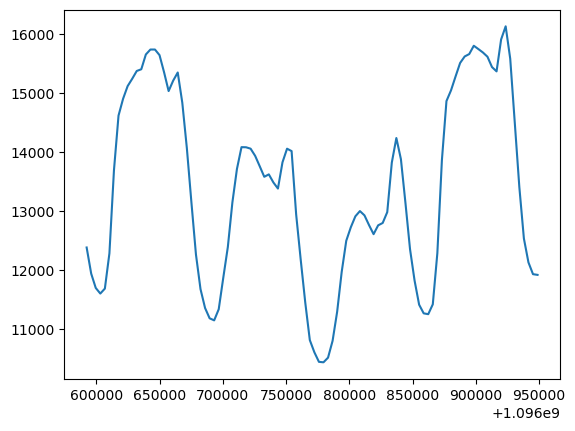

In [10]:
#data plotting
plt.plot(AEP['unix_time'].values[:100], AEP['MW'].values[:100])

To ensure a realistic evaluation of a model, the test set should be constructed as large, continuous segments of the timeline—unseen during training—to evaluate the model’s ability to generalize.

In [11]:
def create_dataloaders(x_data, y_data, L, batch_size, train_size = 0.8):
    test_size  = 1 - train_size

    num = x_data.size - L #Total number of possible sequences
    x_tmp = np.zeros((num, L))
    y_tmp = np.zeros((num, L))
    target_tmp = np.zeros(num)
    for i in range(num):
        x_tmp[i, :] = x_data[i:i+L]
        y_tmp[i, :] = y_data[i:i+L]
        target_tmp[i] = y_data[i+L]

    #Scaling the data
    x_scaler = StandardScaler().fit(x_tmp)
    y_scaler = StandardScaler().fit(y_tmp)
    target_scaler = StandardScaler().fit(target_tmp.reshape(-1, 1))

    x_tmp = x_scaler.transform(x_tmp, copy = True)
    y_tmp = y_scaler.transform(y_tmp, copy = True)
    target_tmp = target_scaler.transform(target_tmp.reshape(-1, 1), copy = True)

    x_tmp = torch.tensor(x_tmp , dtype = torch.float32)
    y_tmp = torch.tensor(y_tmp , dtype = torch.float32)


    X = torch.stack((x_tmp, y_tmp), dim = 2)
    Y = torch.tensor(target_tmp, dtype = torch.float32)
    
    #Creating appropriate test set;
    index = np.arange(num)
    sub_seq = 10*L 
    test_index = np.arange(0, num - sub_seq, num//100) 
    for item in test_index:
        test_index = np.concatenate((test_index, np.arange(item+1, item+1+sub_seq, 1)))

    train_index = np.delete(index, test_index)
    X_train, Y_train = X[train_index], Y[train_index]
    X_test, Y_test = X[test_index], Y[test_index]

    
    train_dataset = TensorDataset(X_train, Y_train)
    test_dataset = TensorDataset(X_test, Y_test)
    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)



    return x_scaler, y_scaler , target_scaler, train_dataloader, test_dataloader

In [12]:
L = 17 #L - window lenght
batch_size = 400

x = copy.deepcopy(AEP['unix_time'].values)
y = copy.deepcopy(AEP['MW'].values)

x_scaler, y_scaler, target_scaler,  train_dataloader,  test_dataloader = create_dataloaders(x, y, L, batch_size)

The model: 3 stacked RNN, with hidden_size = 25 and dropout regularization;

In [13]:
X_tmp, Y_tmp = next(iter(train_dataloader))

input_size = X_tmp.shape[-1]
hidden_size = 25
num_layers = 3

class myRNN(nn.Module):
    
    def __init__(self, hidden_size = hidden_size, input_size=input_size, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers,
             nonlinearity = 'tanh', bias = True, batch_first = True, dropout = 0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h = None):
        output , _ = self.rnn(x, h)
        out = self.fc(output[:, -1, :])
        return out

In [14]:
learning_rate = 0.01
epochs = 50

model = myRNN()
device = 'cuda'
model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    j = 0
    cum_loss = .0
    
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X).to(device)
        loss = loss_fn(pred, y).to(device)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        
        if batch % 50 == 0:
            j+=1
            loss, current = loss.item(), batch * batch_size + len(X)
            cum_loss += loss
            print(f"batch {batch} loss: {loss:.5}")
            
    print(f'mean train loss : {cum_loss/j:.5}', )            
    return cum_loss/j

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader)
    loss = .0

    with torch.no_grad():
        for (X, y) in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X).to(device)
            loss += loss_fn(pred, y).to(device)


        
    print(f'test loss: {loss/size:.5}')
    return float(loss/size)

In [16]:
train_losses = list()
test_losses = list()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train_loop(train_dataloader, model, loss_fn, optimizer))
    test_losses.append(test_loop(test_dataloader, model, loss_fn))
print("Done!")

Epoch 1
-------------------------------
batch 0 loss: 0.93644
batch 50 loss: 0.039926
batch 100 loss: 0.026559
batch 150 loss: 0.022176
batch 200 loss: 0.020391
batch 250 loss: 0.021325
mean train loss : 0.1778
test loss: 0.013931
Epoch 2
-------------------------------
batch 0 loss: 0.02288
batch 50 loss: 0.018795
batch 100 loss: 0.020884
batch 150 loss: 0.016844
batch 200 loss: 0.018667
batch 250 loss: 0.01881
mean train loss : 0.01948
test loss: 0.012532
Epoch 3
-------------------------------
batch 0 loss: 0.021397
batch 50 loss: 0.018325
batch 100 loss: 0.015509
batch 150 loss: 0.018019
batch 200 loss: 0.015909
batch 250 loss: 0.014622
mean train loss : 0.017297
test loss: 0.010262
Epoch 4
-------------------------------
batch 0 loss: 0.015639
batch 50 loss: 0.016962
batch 100 loss: 0.014223
batch 150 loss: 0.014994
batch 200 loss: 0.016634
batch 250 loss: 0.017351
mean train loss : 0.015967
test loss: 0.010198
Epoch 5
-------------------------------
batch 0 loss: 0.016487
batch 5

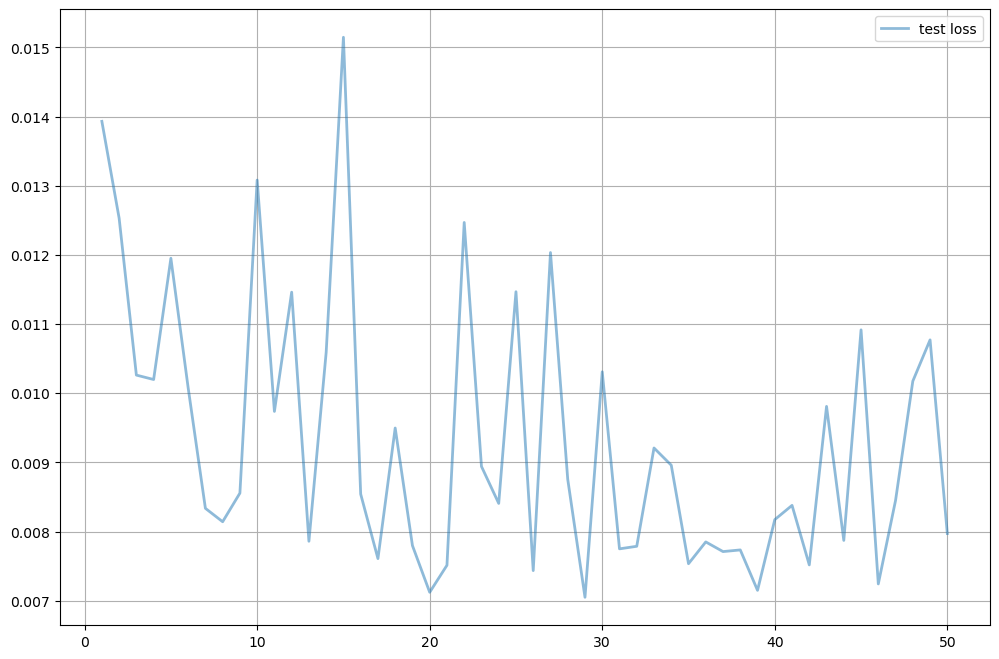

In [17]:
plt.figure(figsize = (12, 8))
#plt.plot(np.arange(1, epochs + 1), np.array(train_losses), label = 'train loss', lw = 2, alpha = 0.5)
plt.plot(np.arange(1, epochs + 1), np.array(test_losses), label = 'test loss', lw = 2, alpha = 0.5)
plt.legend()
plt.grid()

To evaluate model we plot its predictions on training sample:

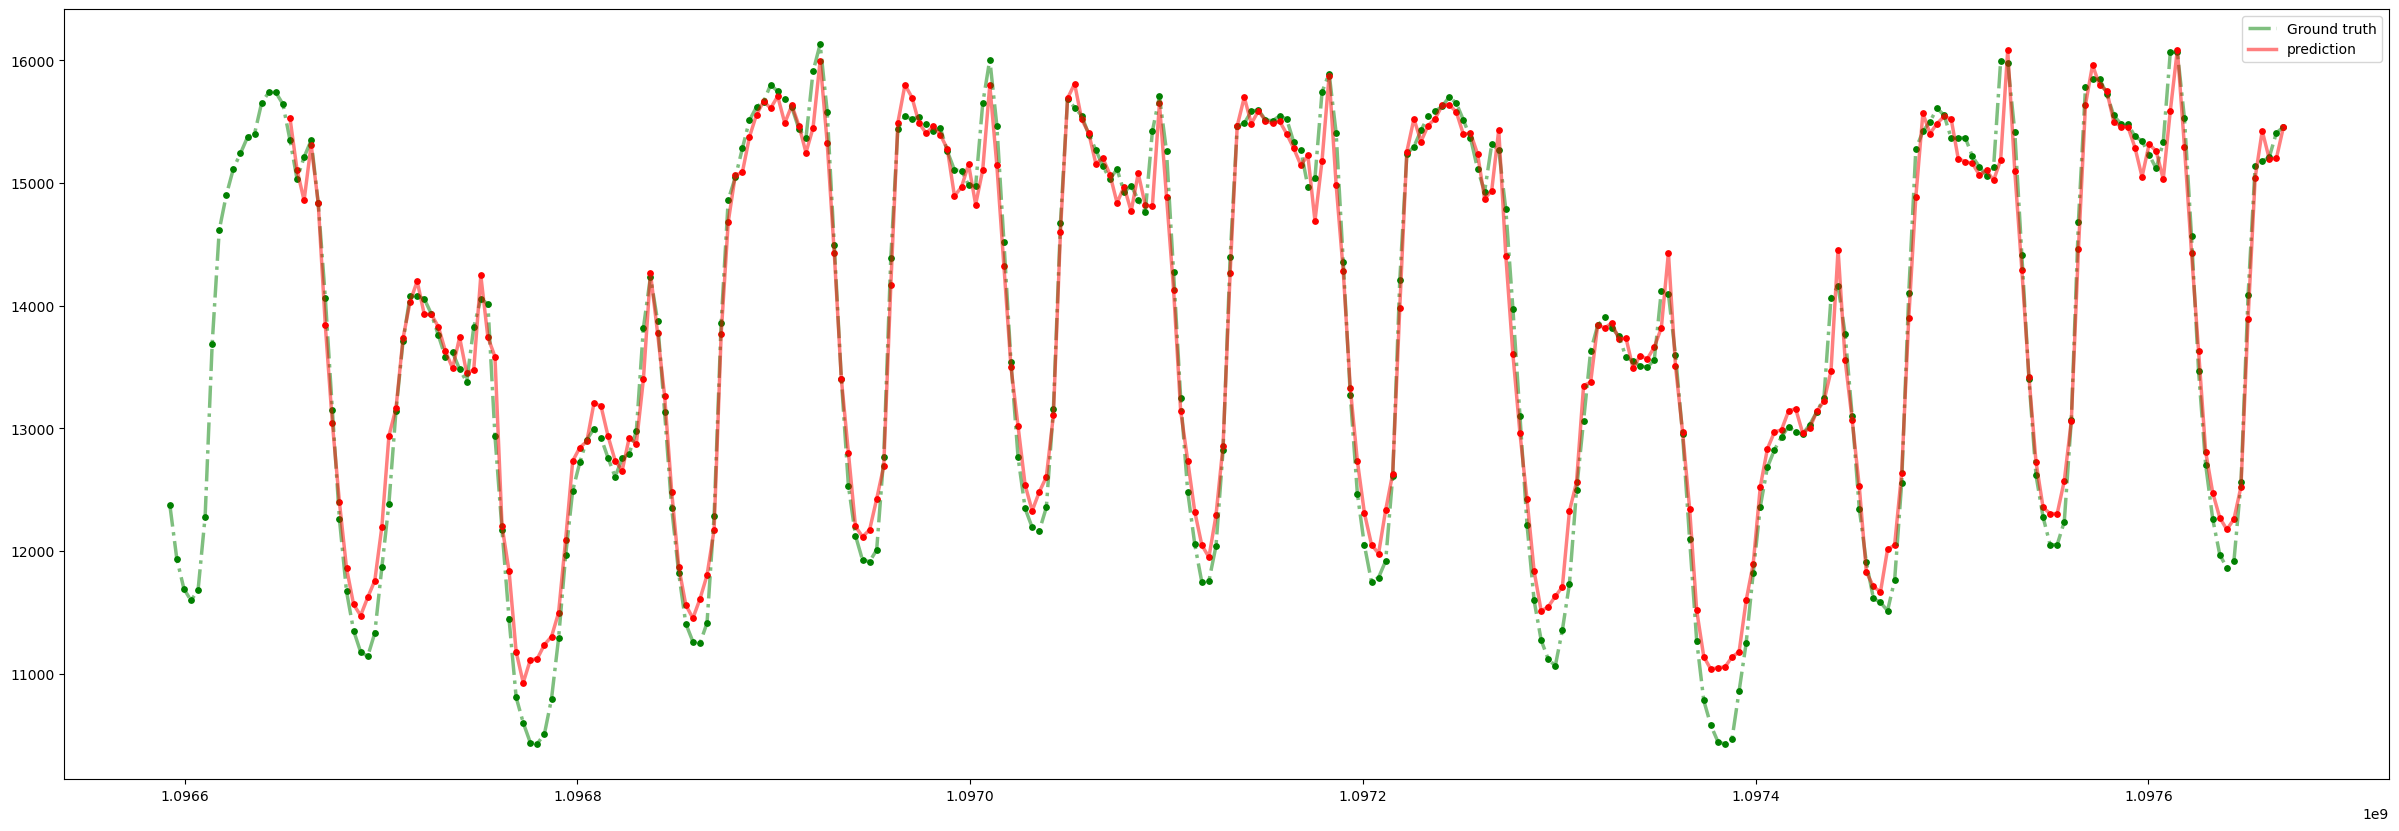

In [18]:
model.to('cpu')

num = 300

y_pred= copy.deepcopy(y)

i = L #index of the time step to be inferred

while i!= num-1:
    x_scaled = x_scaler.transform(x[i-L: i].reshape(1, -1), copy = True)
    y_scaled = y_scaler.transform(y[i-L: i].reshape(1, -1), copy = True)

    x_scaled = torch.tensor(x_scaled, dtype = torch.float32)
    y_scaled = torch.tensor(y_scaled, dtype = torch.float32)

    X = torch.stack((x_scaled, y_scaled), dim = 2)

    y_pred_scaled = np.array(model(X).detach()).reshape(-1, 1)
    y_pred[i] = target_scaler.inverse_transform(y_pred_scaled, copy = True)[0, 0]
    i += 1


plt.figure(figsize = (30, 10))
plt.plot(x[:num], y[:num], c = 'green', ls = '-.', alpha = 0.5, lw = 2.5, label = 'Ground truth')
plt.scatter(x[:num], y[:num], c = 'green',  s = 15)
plt.plot(x[L:num], y_pred[L:num], c = 'red', alpha = 0.5, lw = 2.5, label = 'prediction')
plt.scatter(x[L:num], y_pred[L:num], c = 'red', s = 15)
plt.legend()
plt.show()

Out of sample performance. Here not every sequence is consecutive.

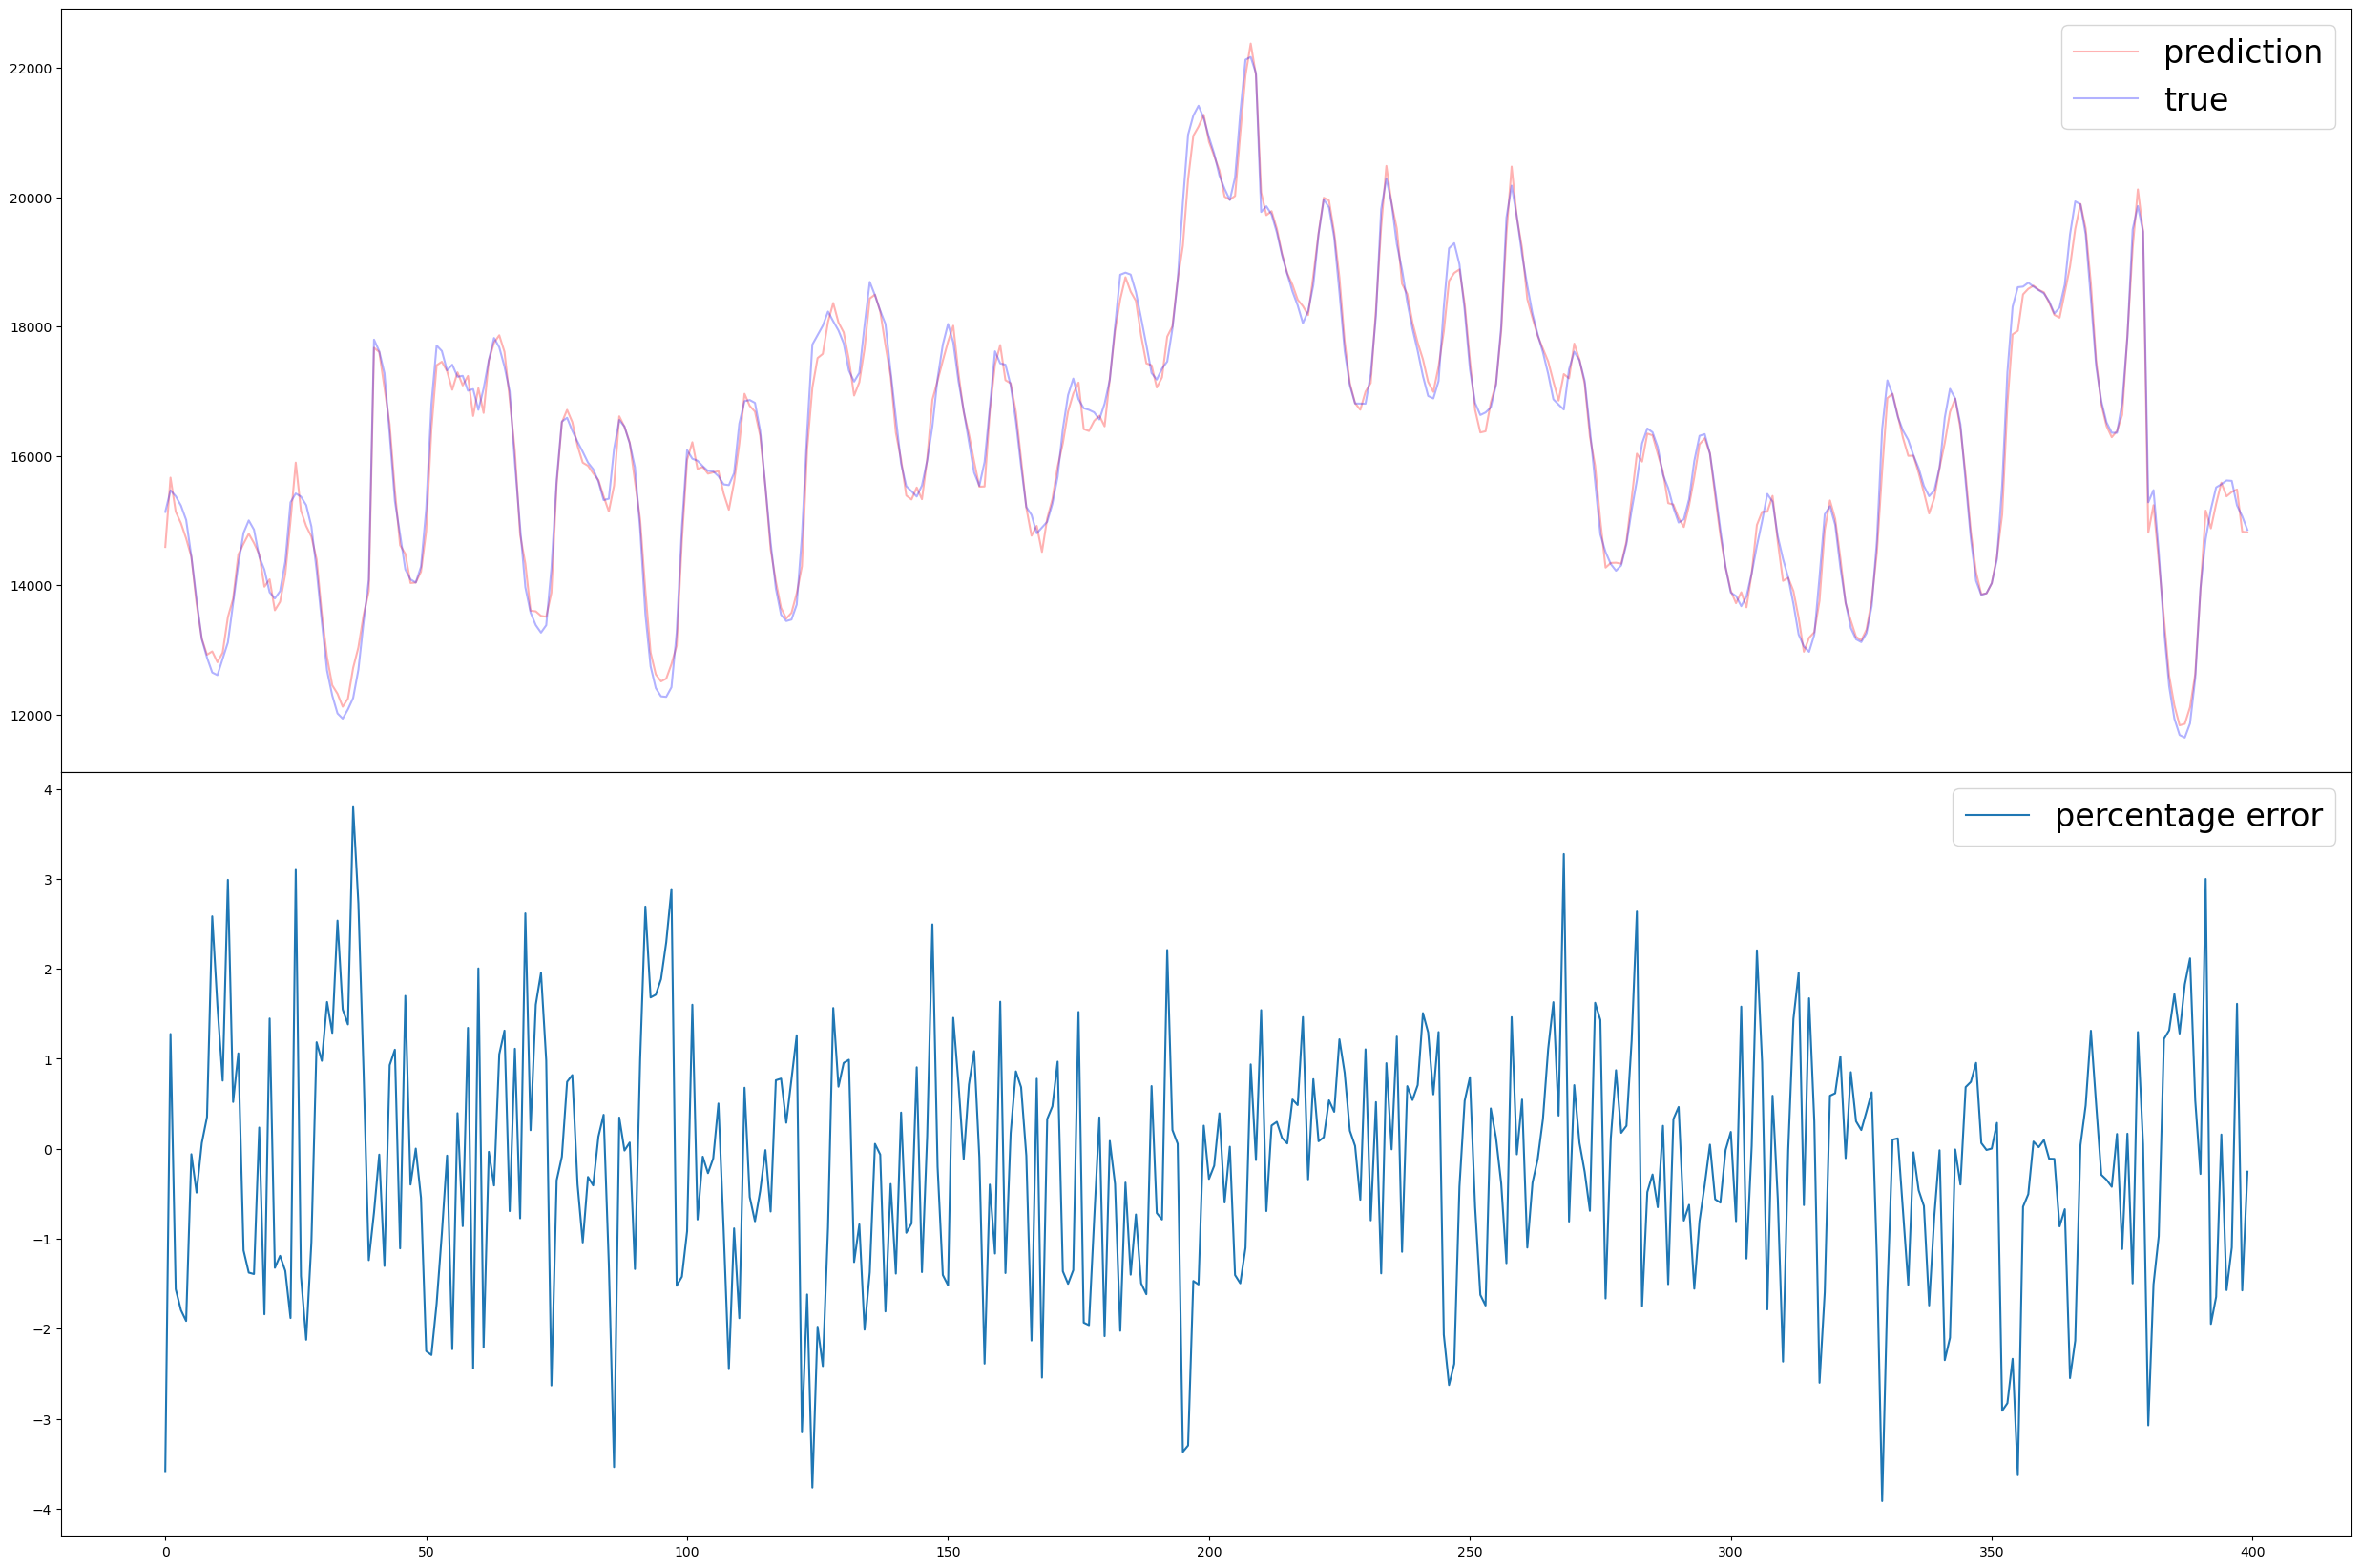

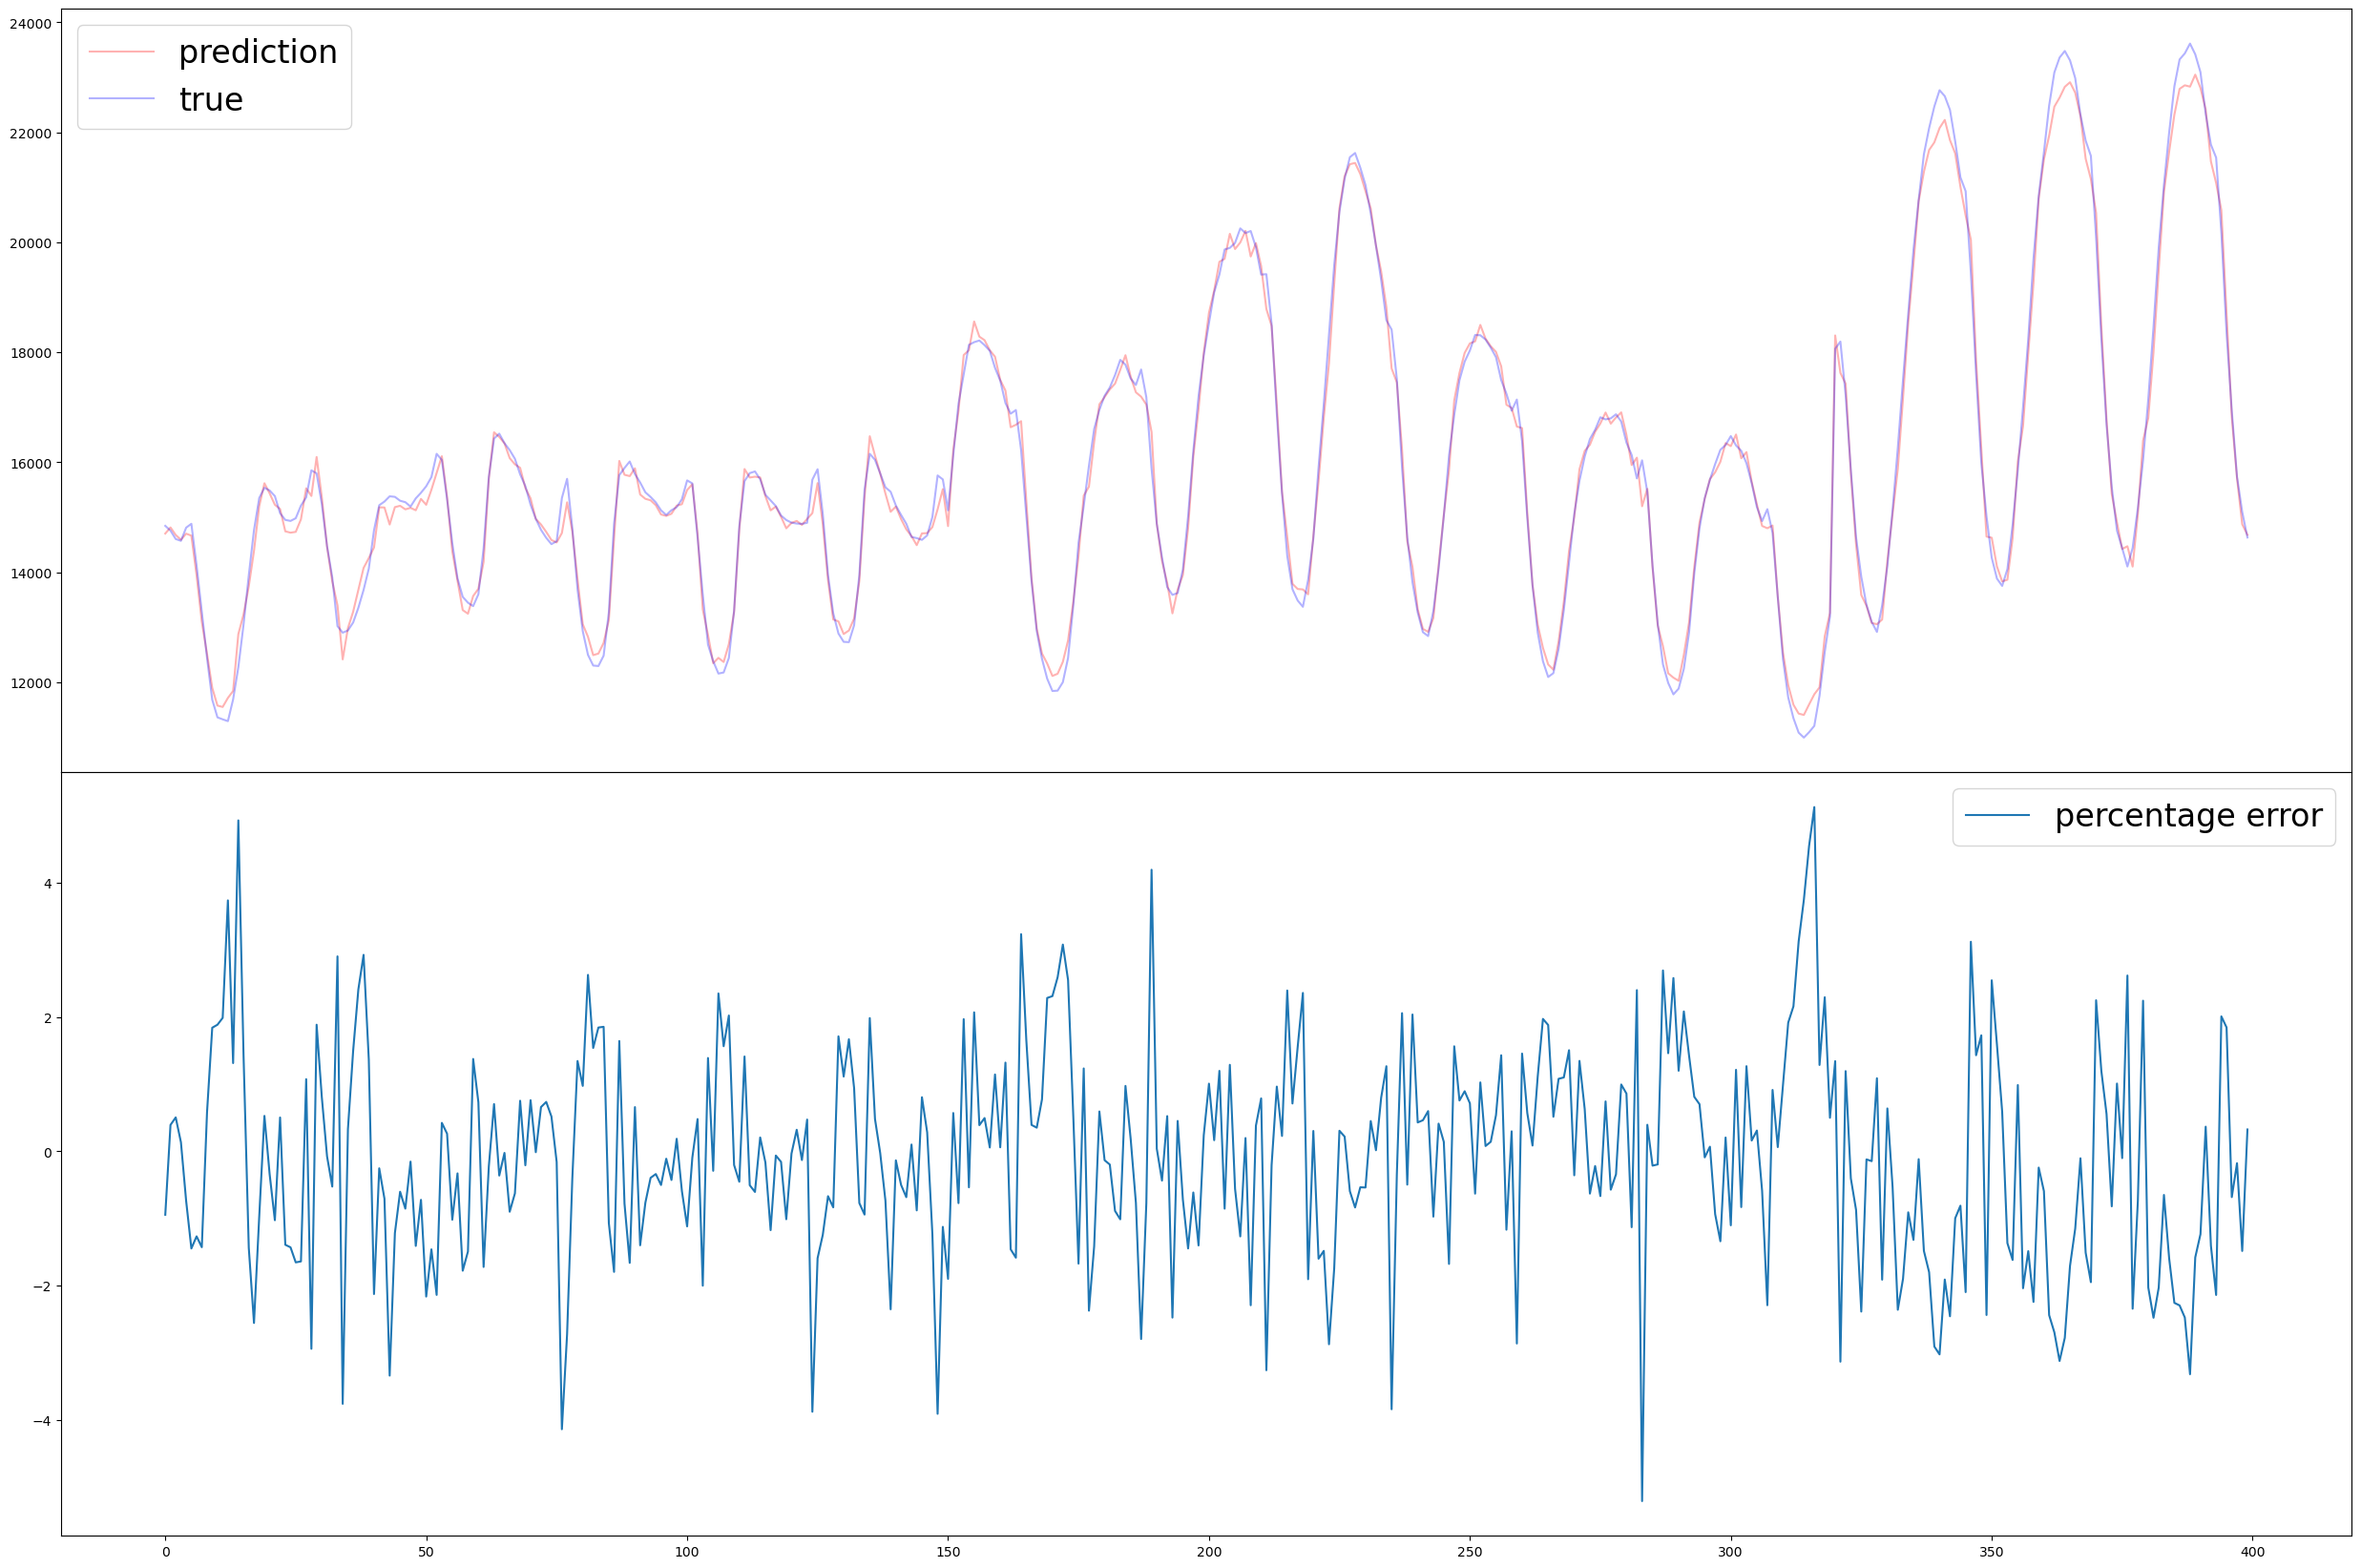

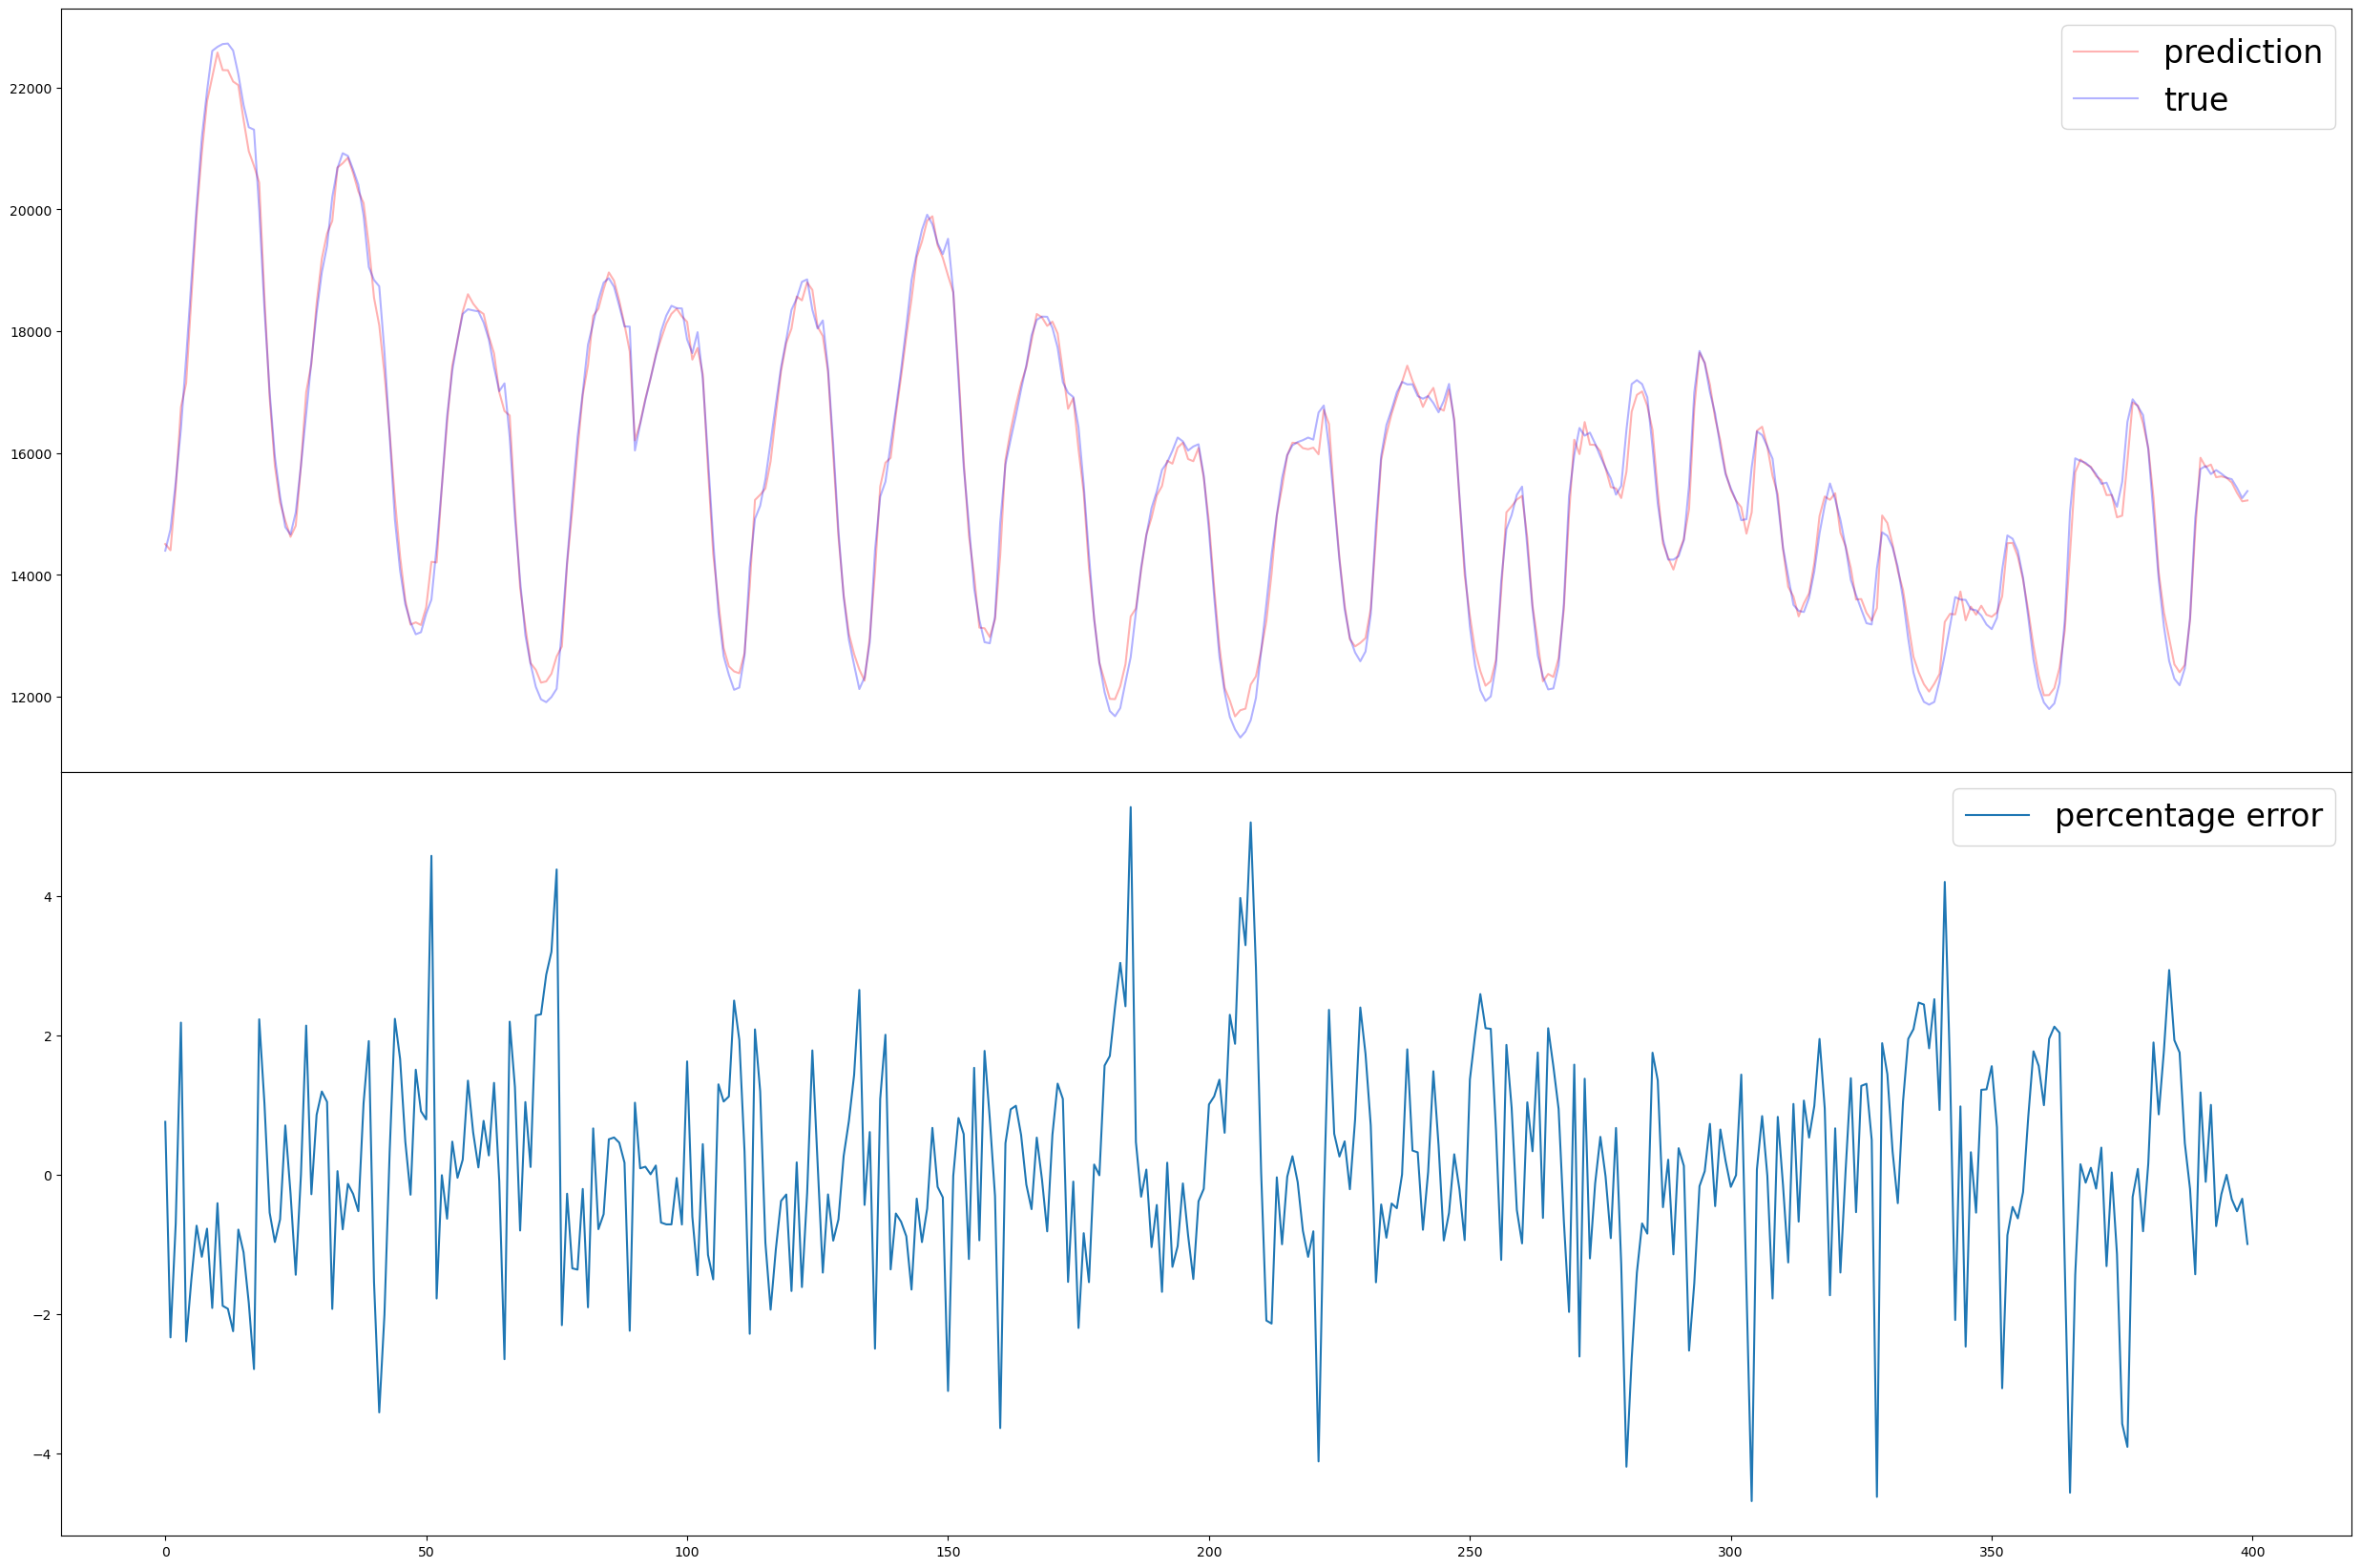

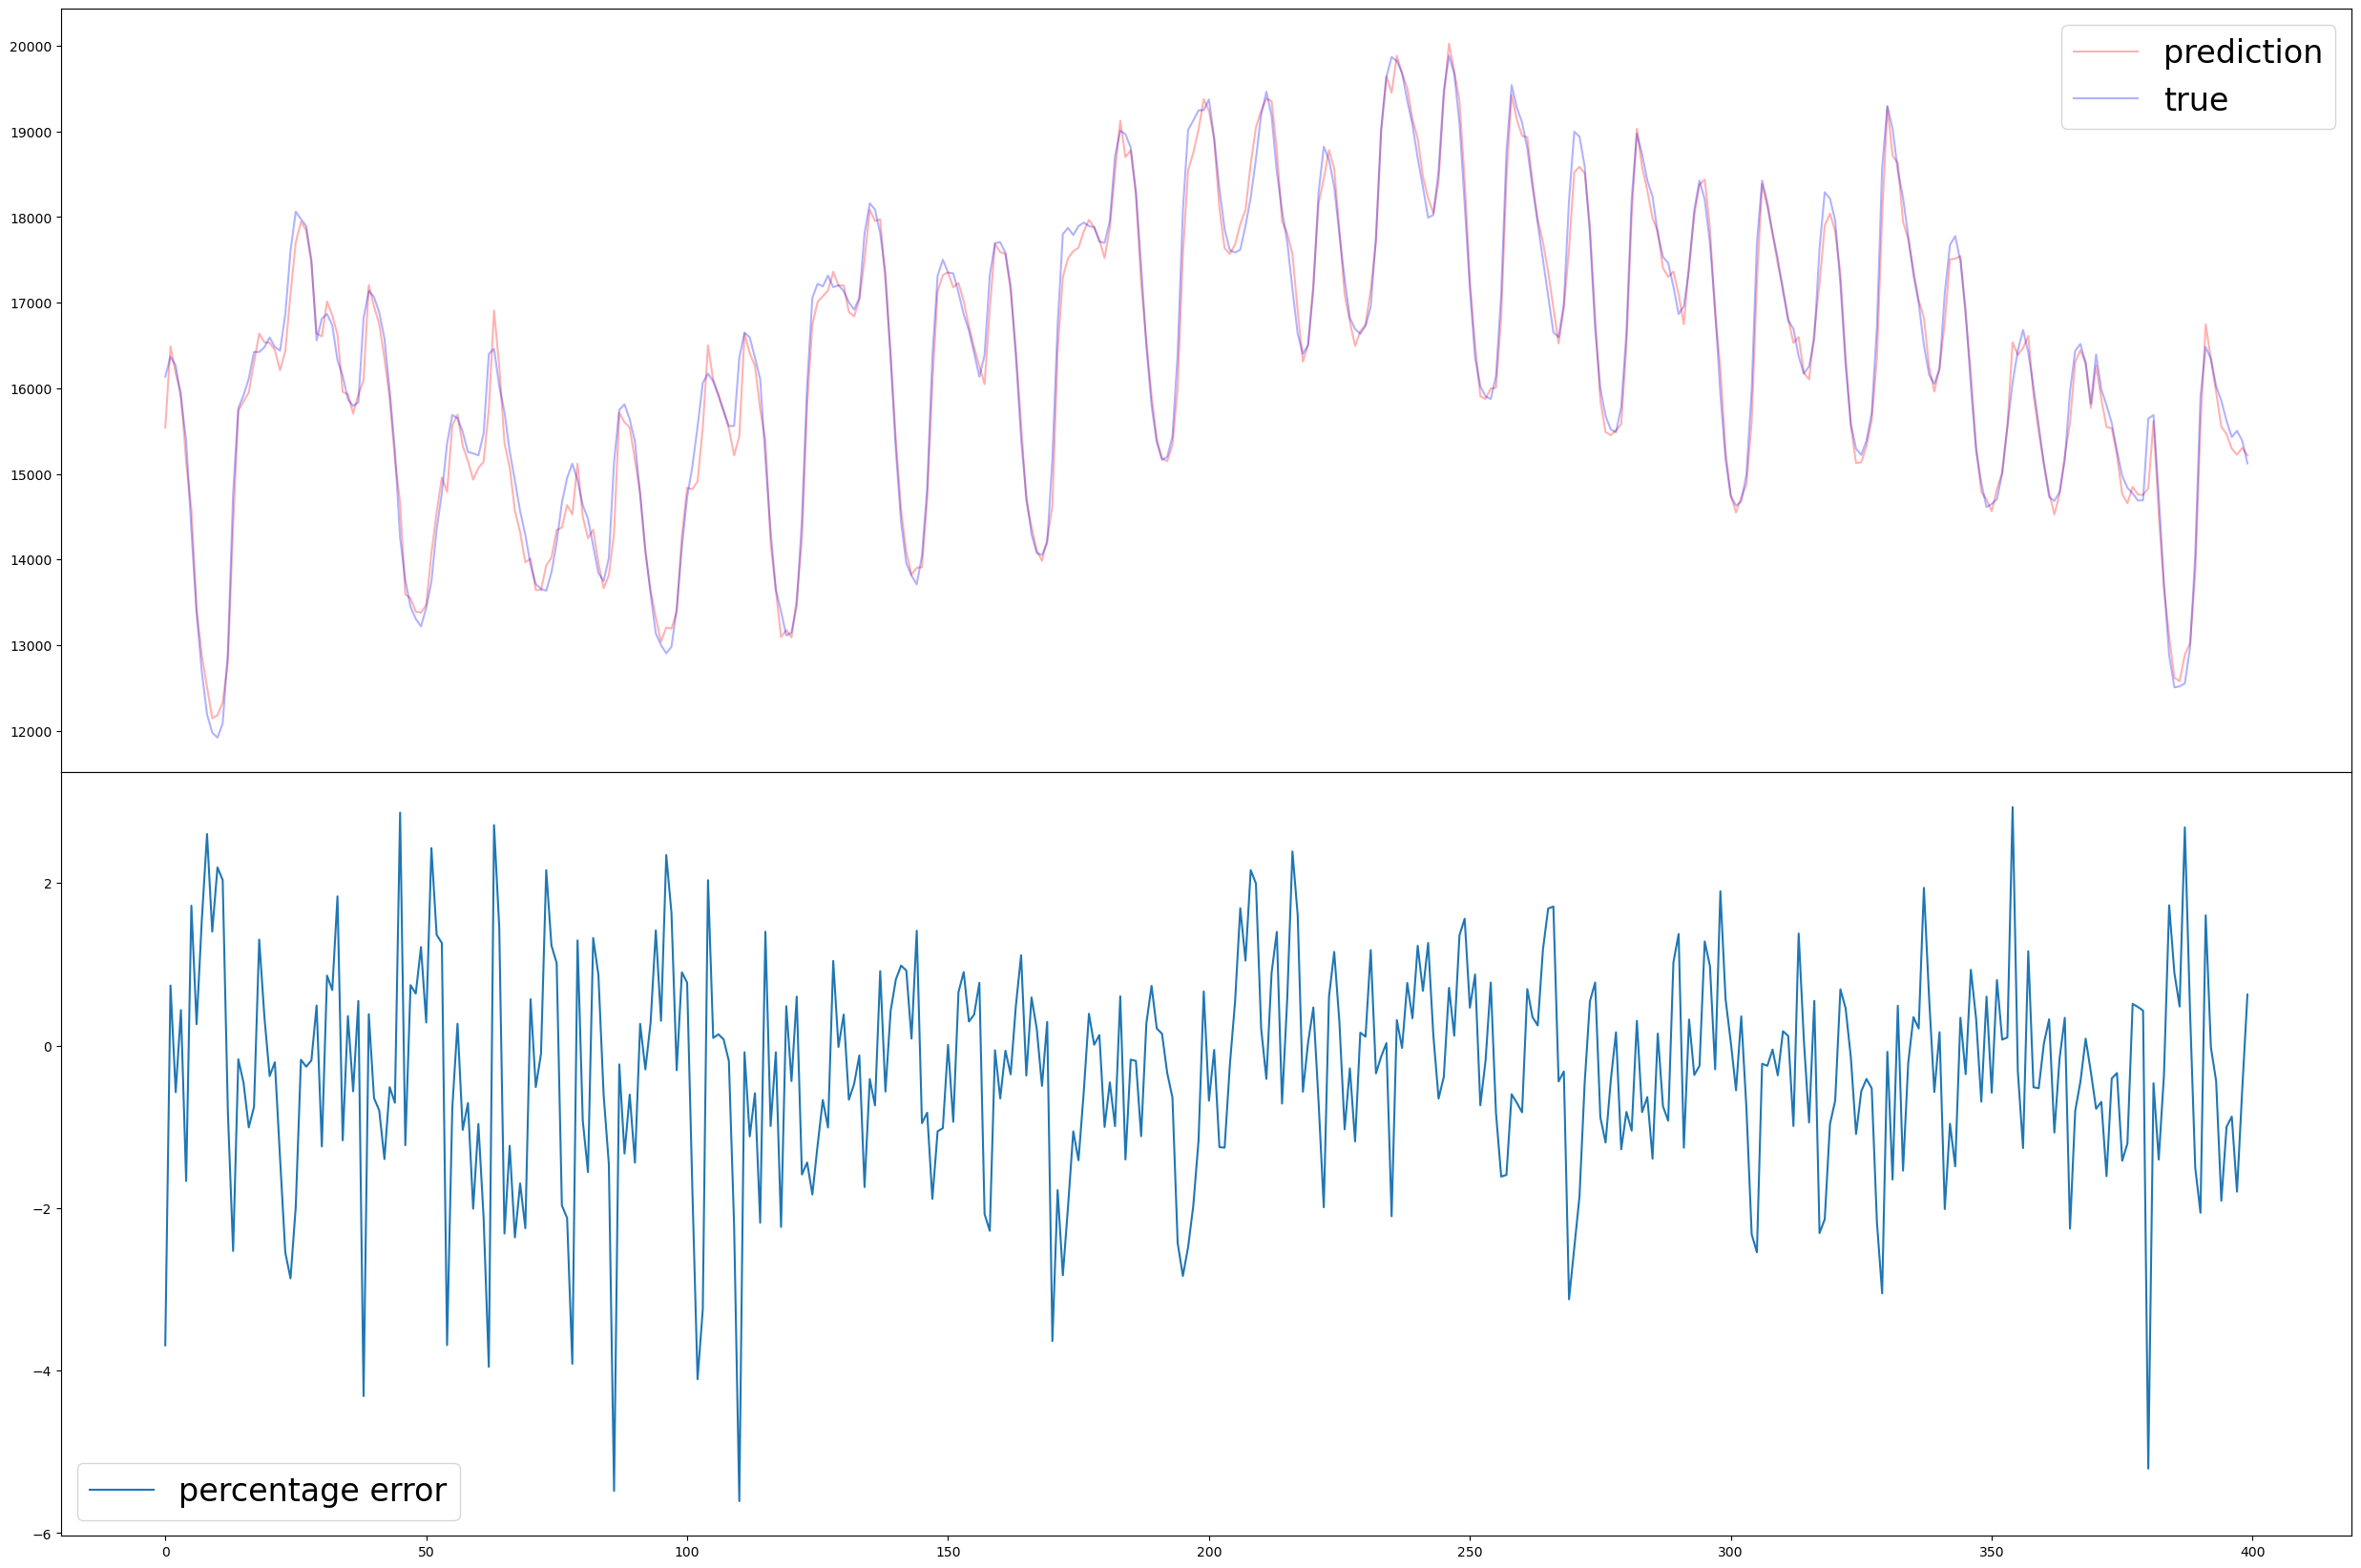

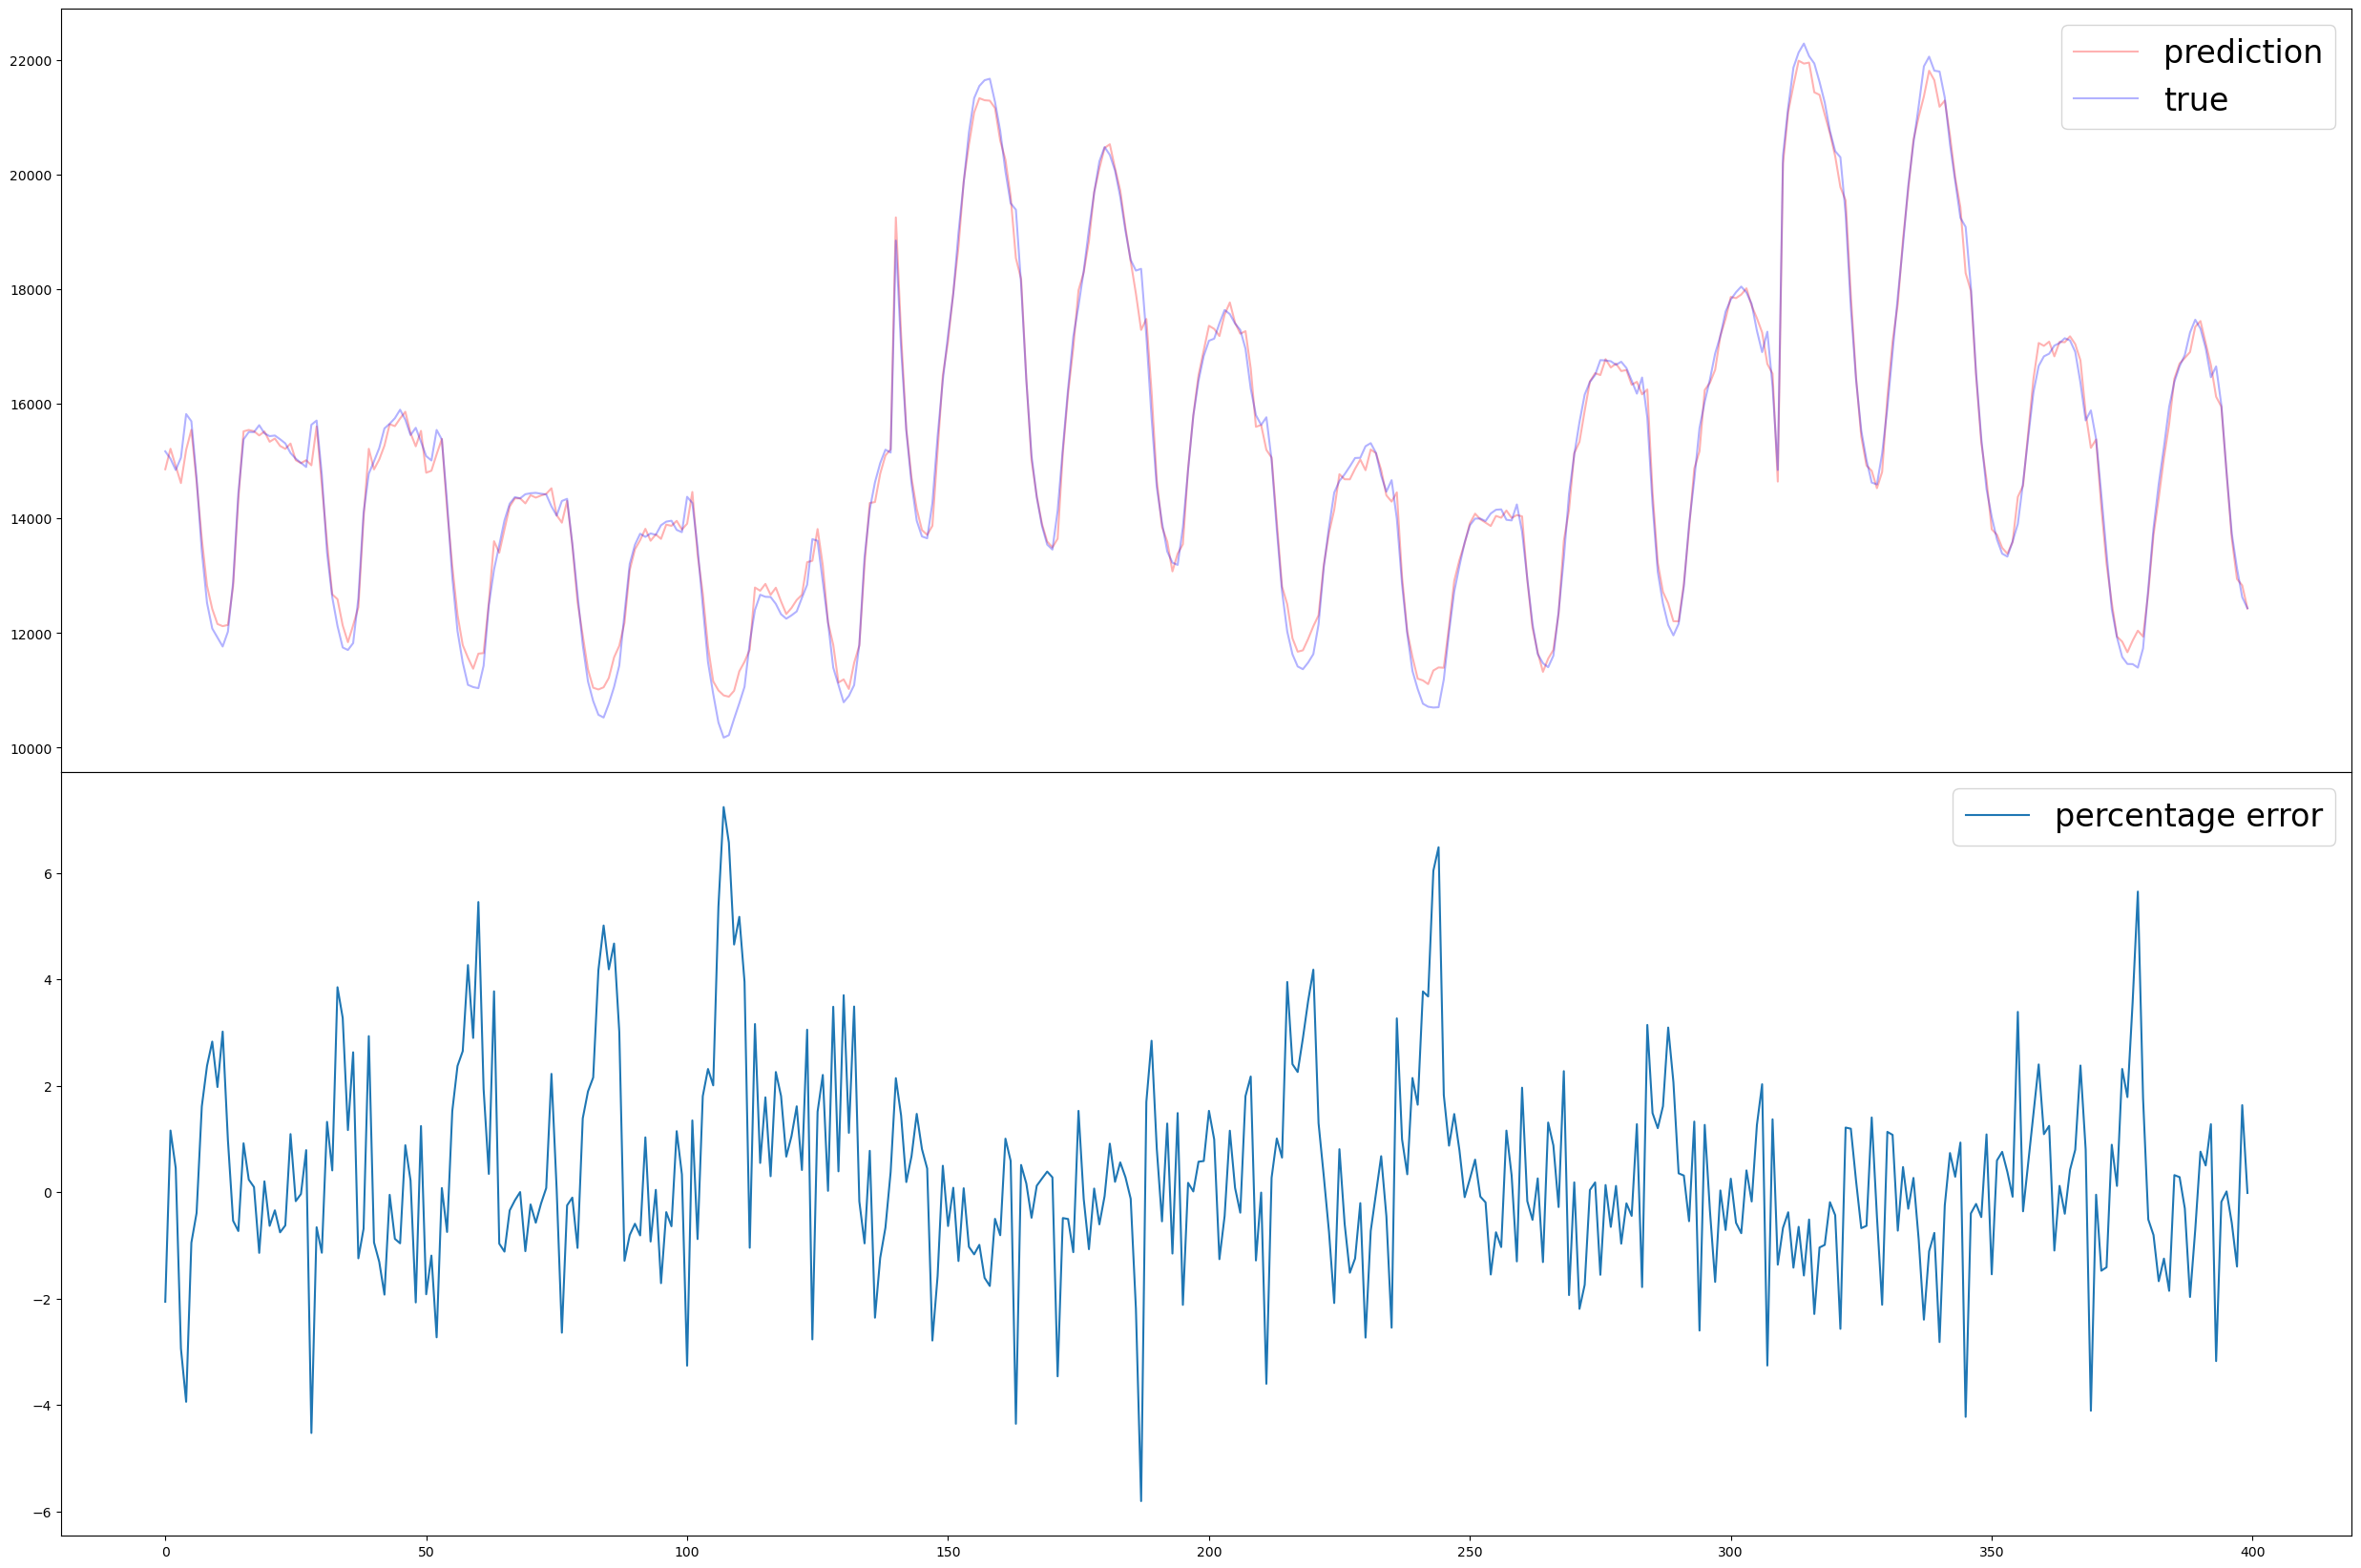

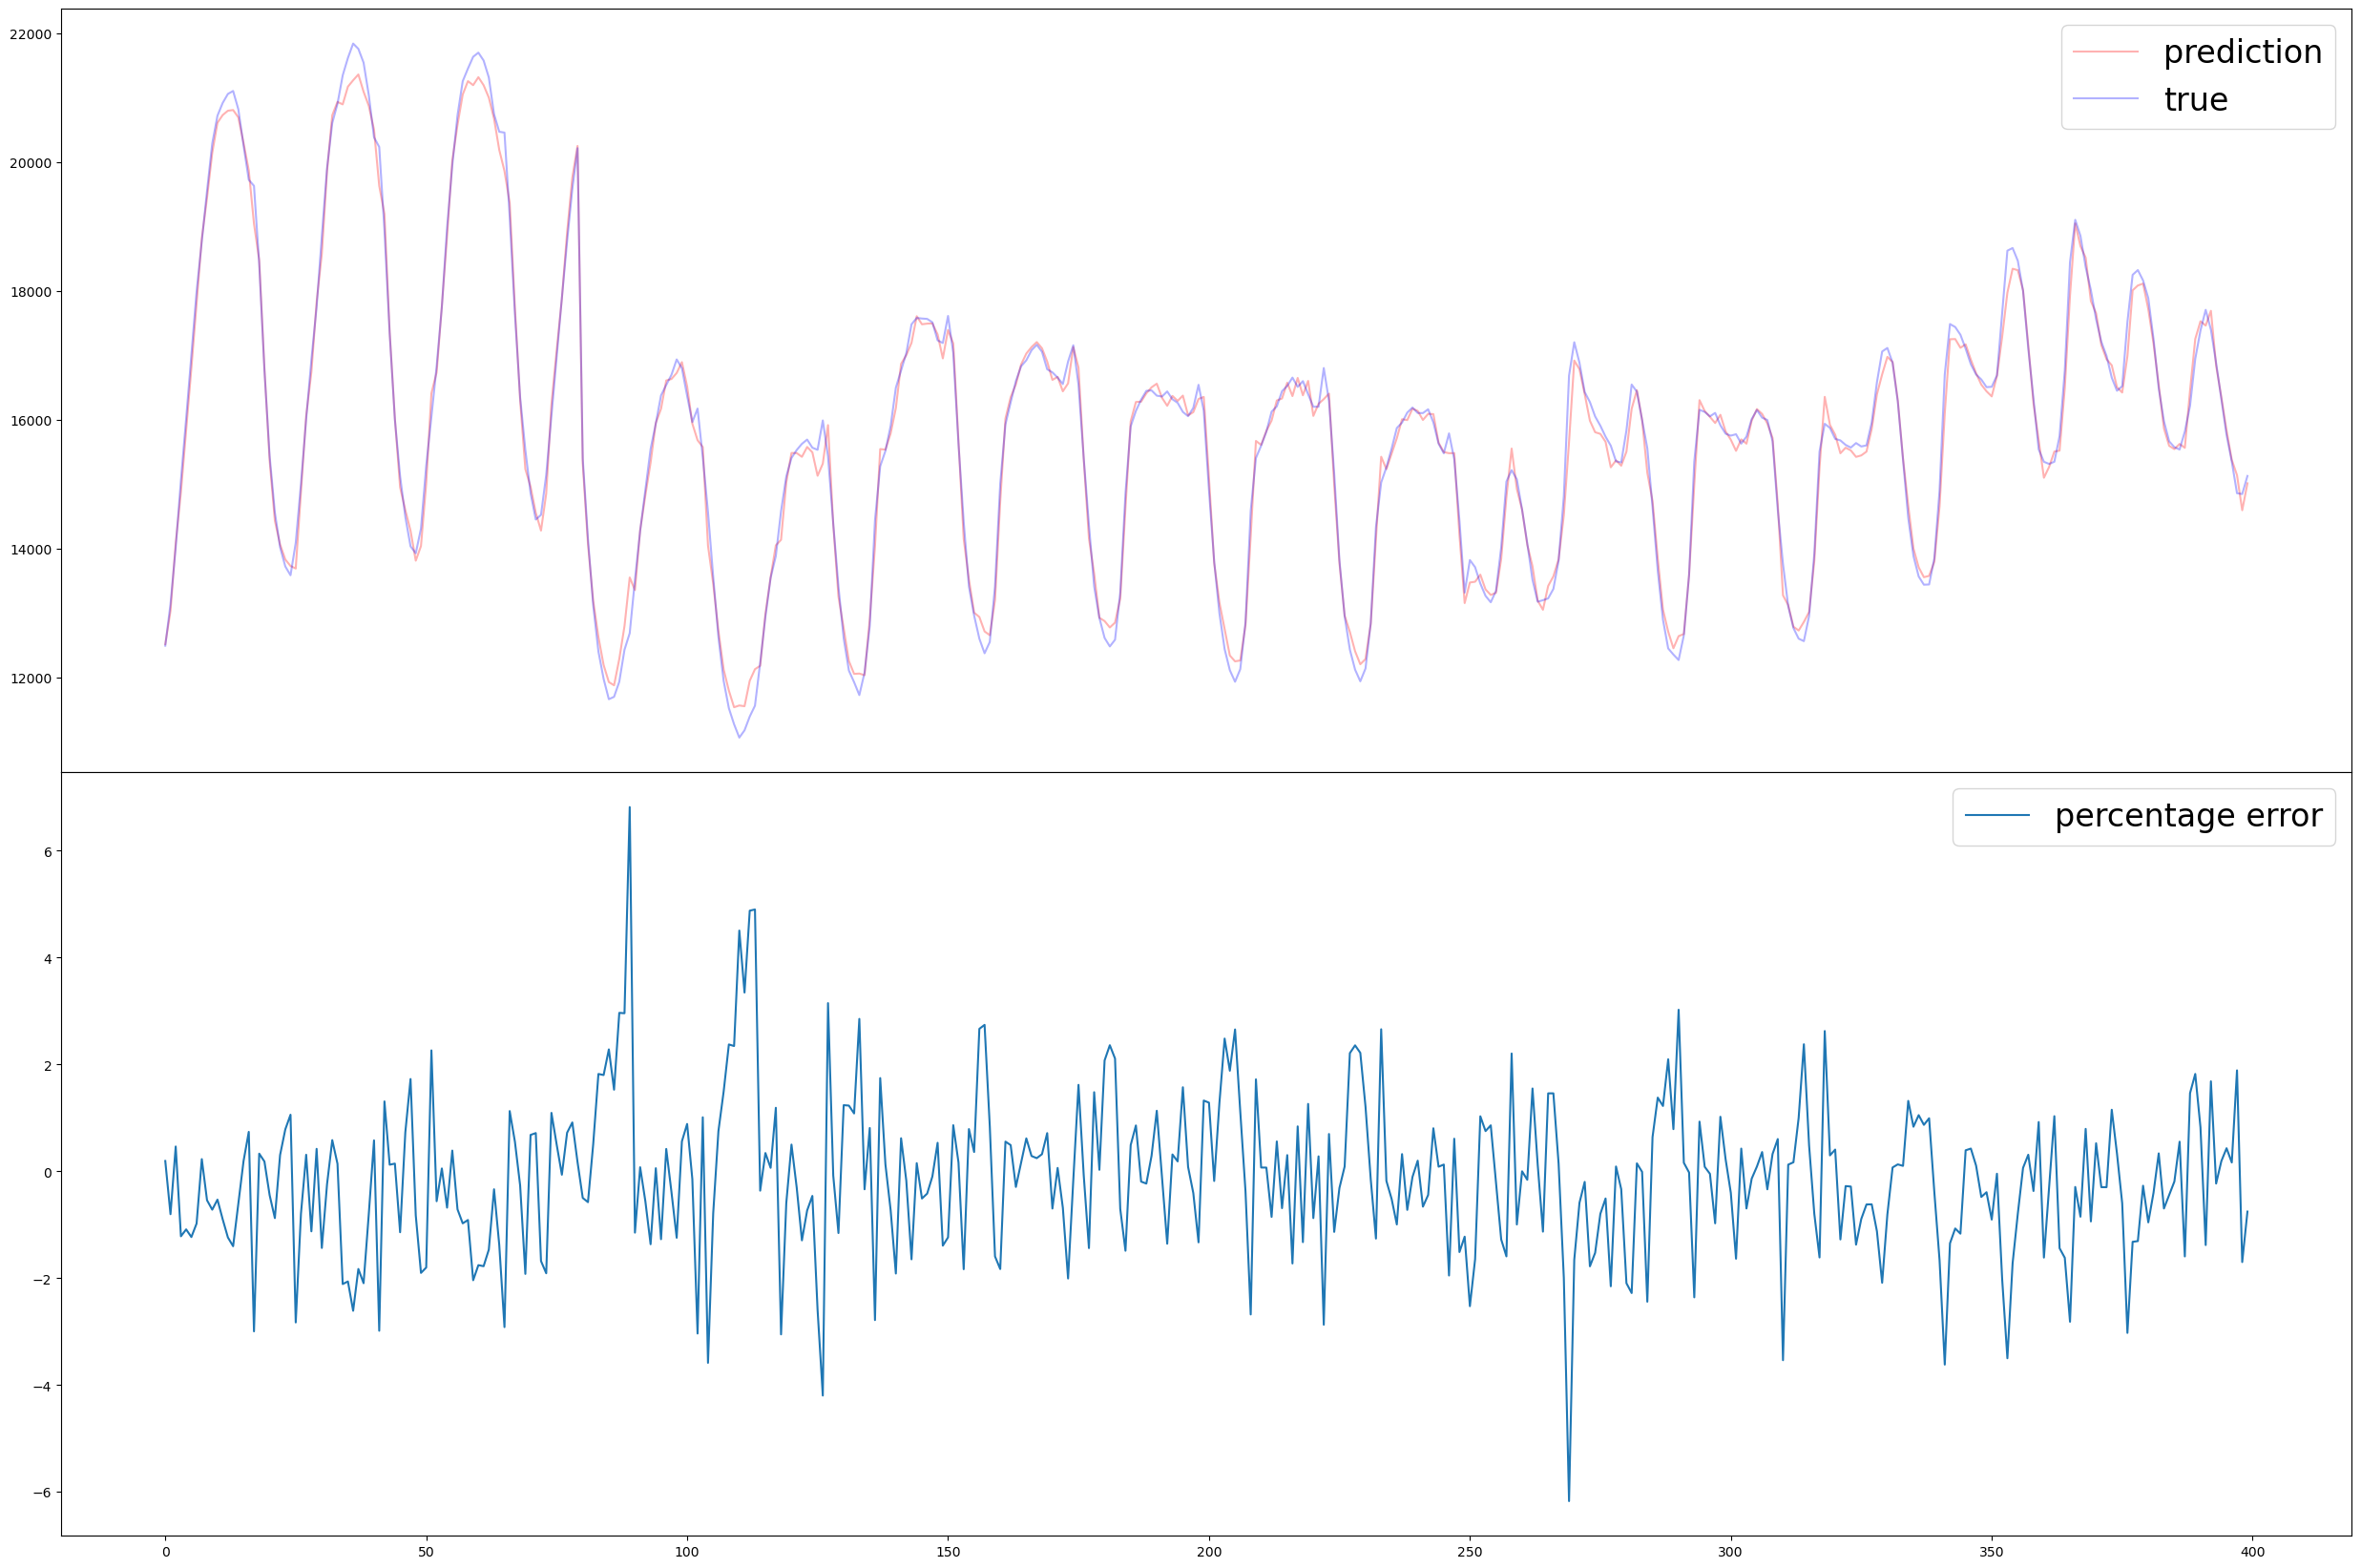

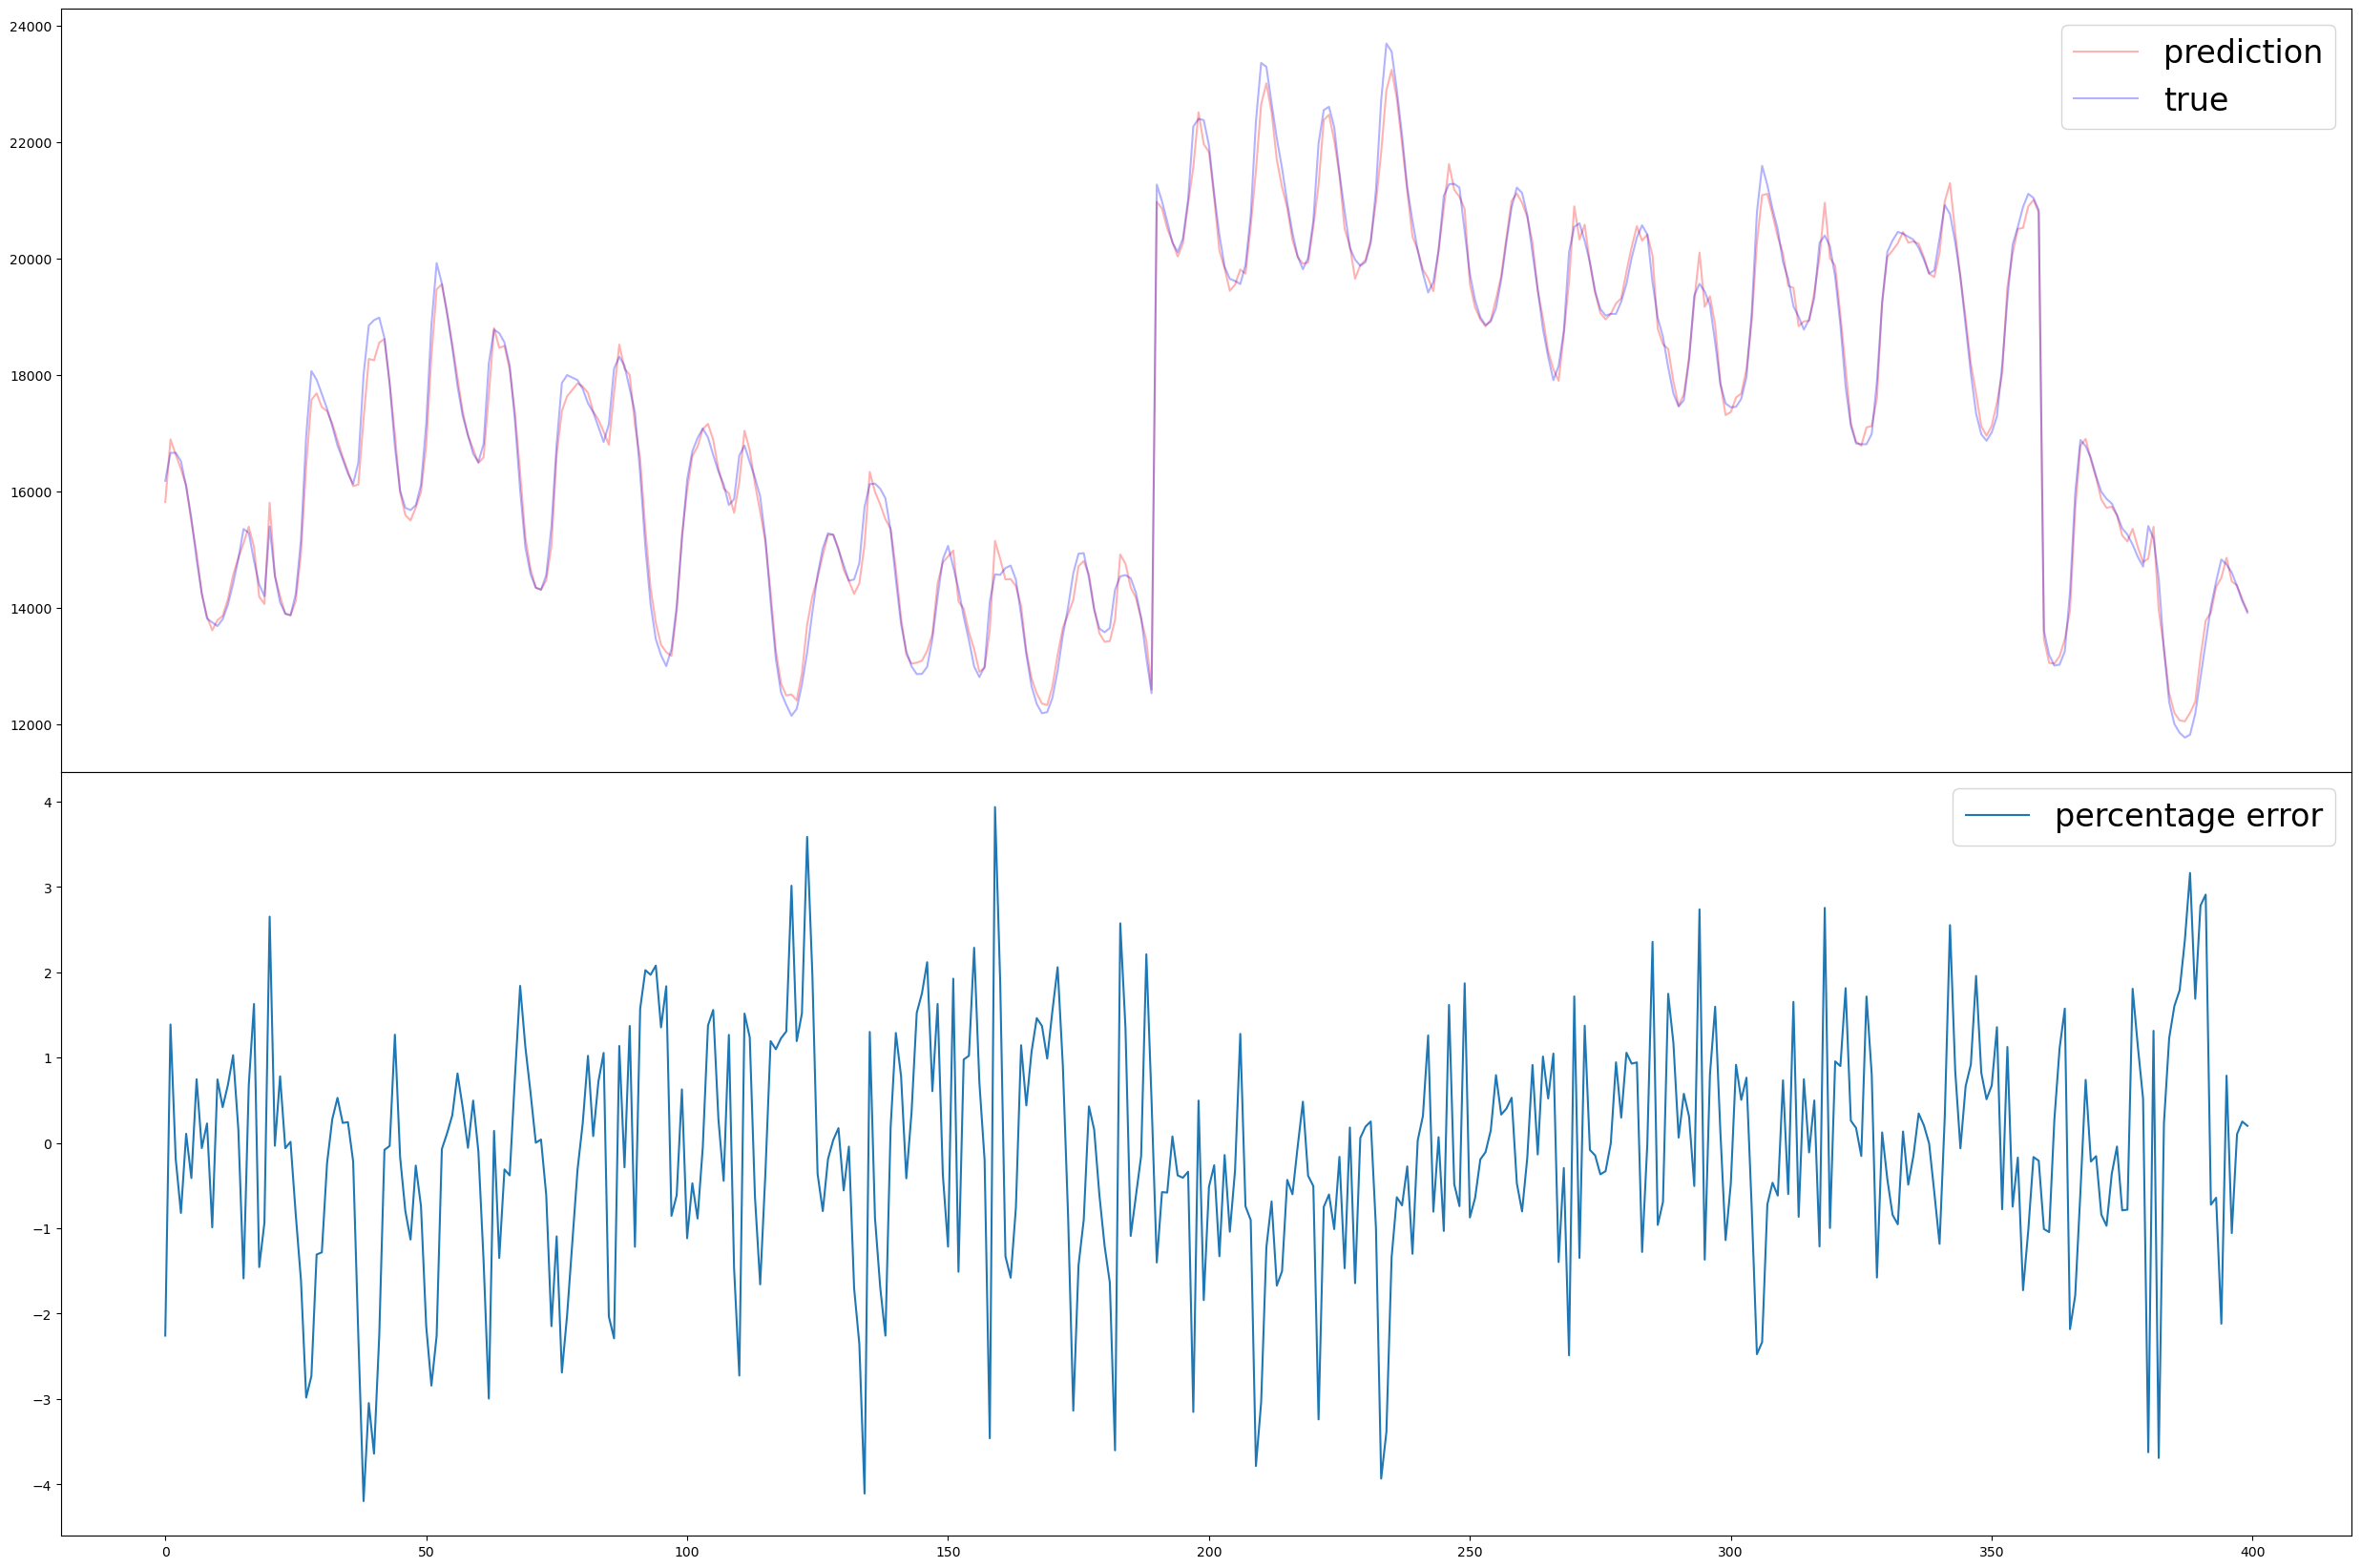

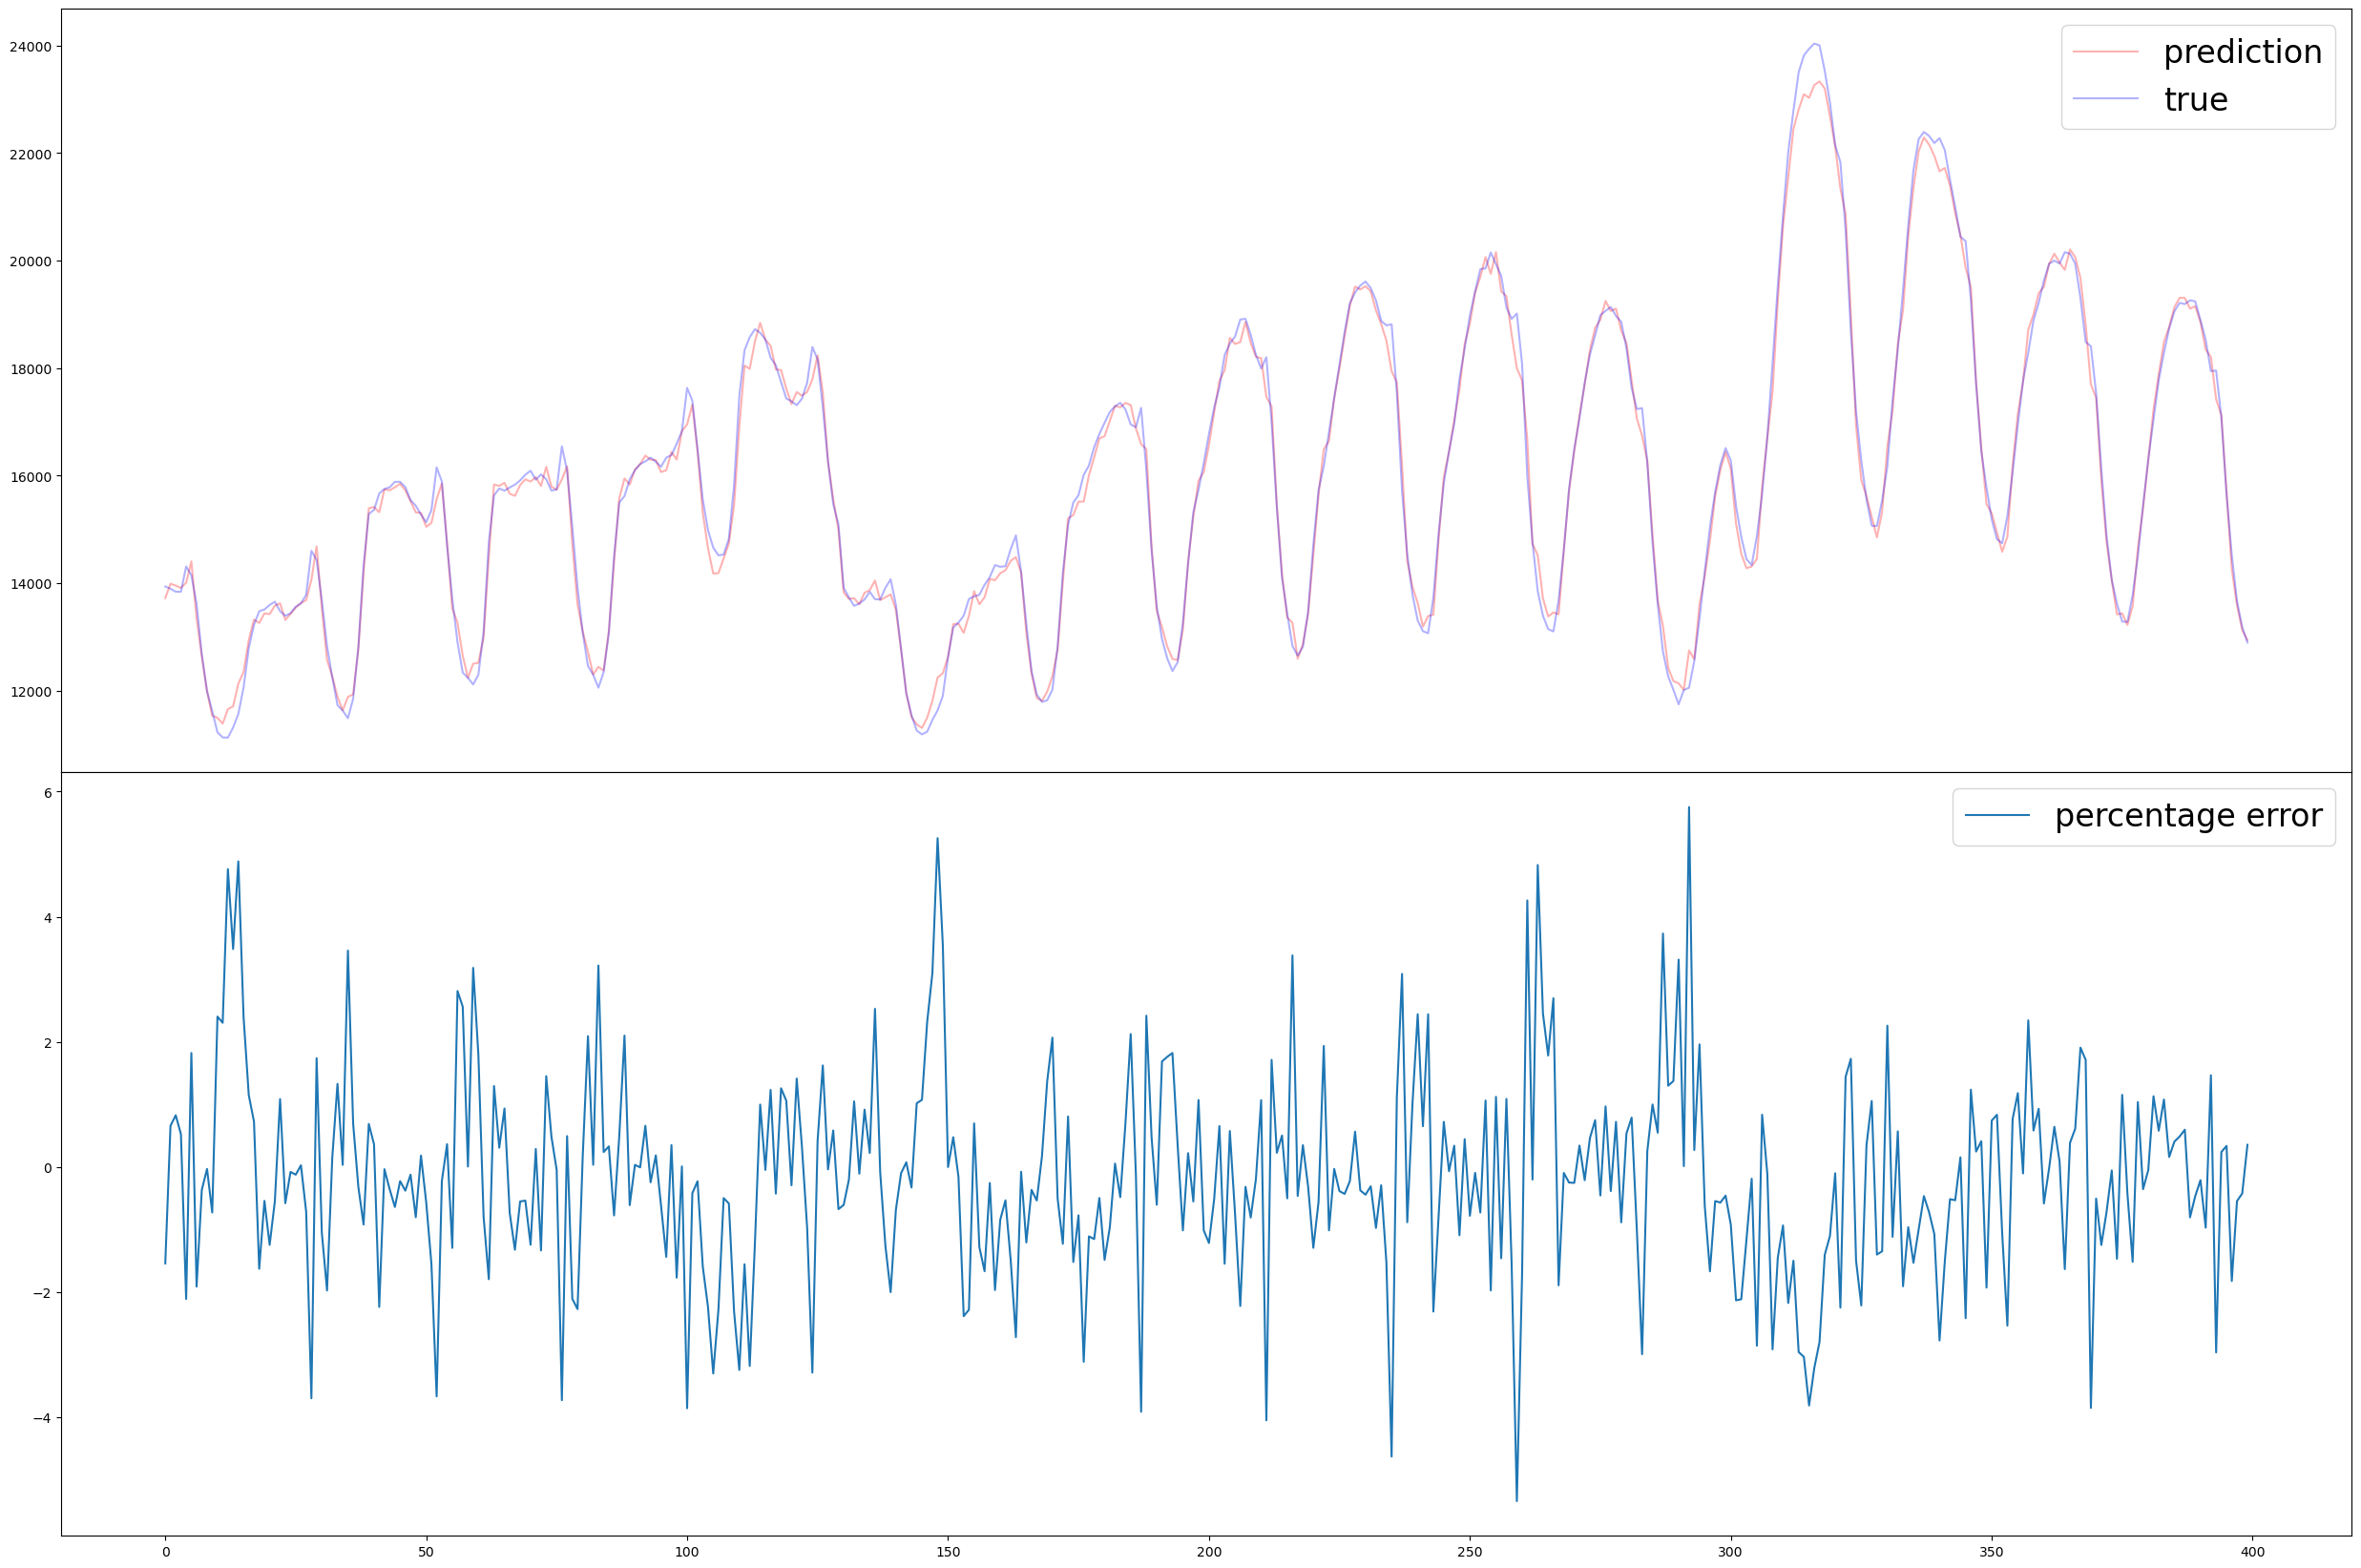

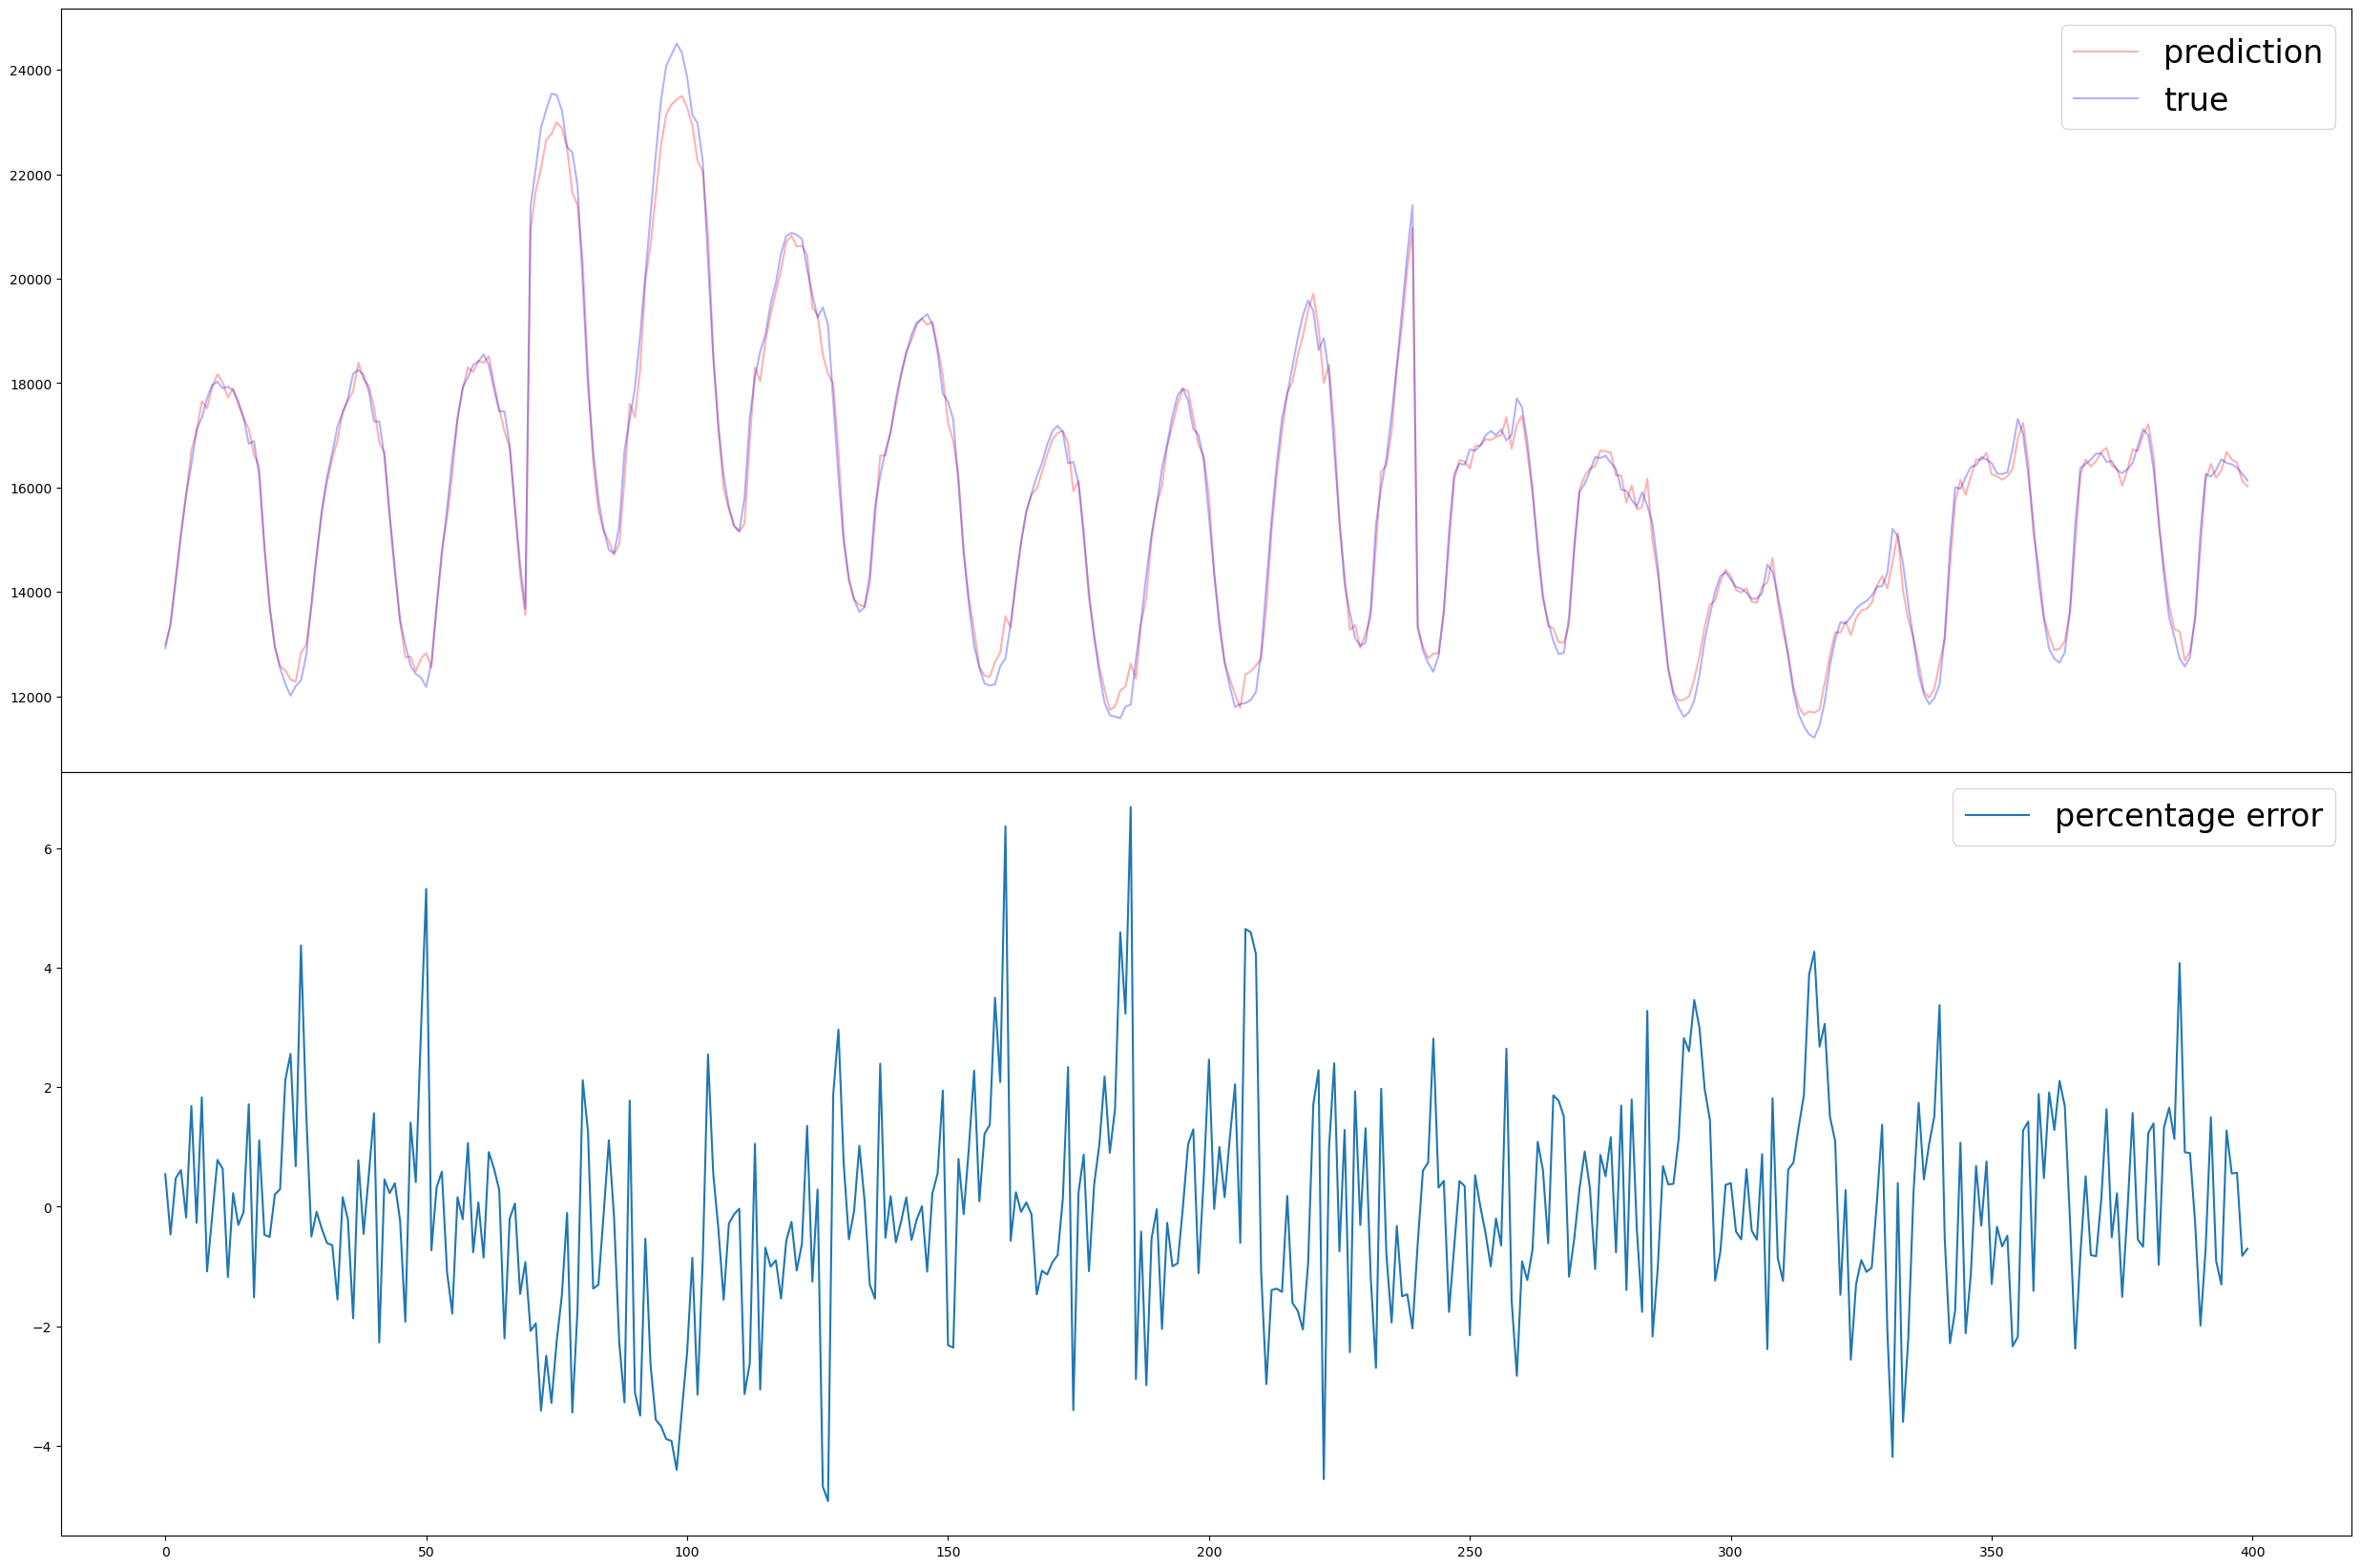

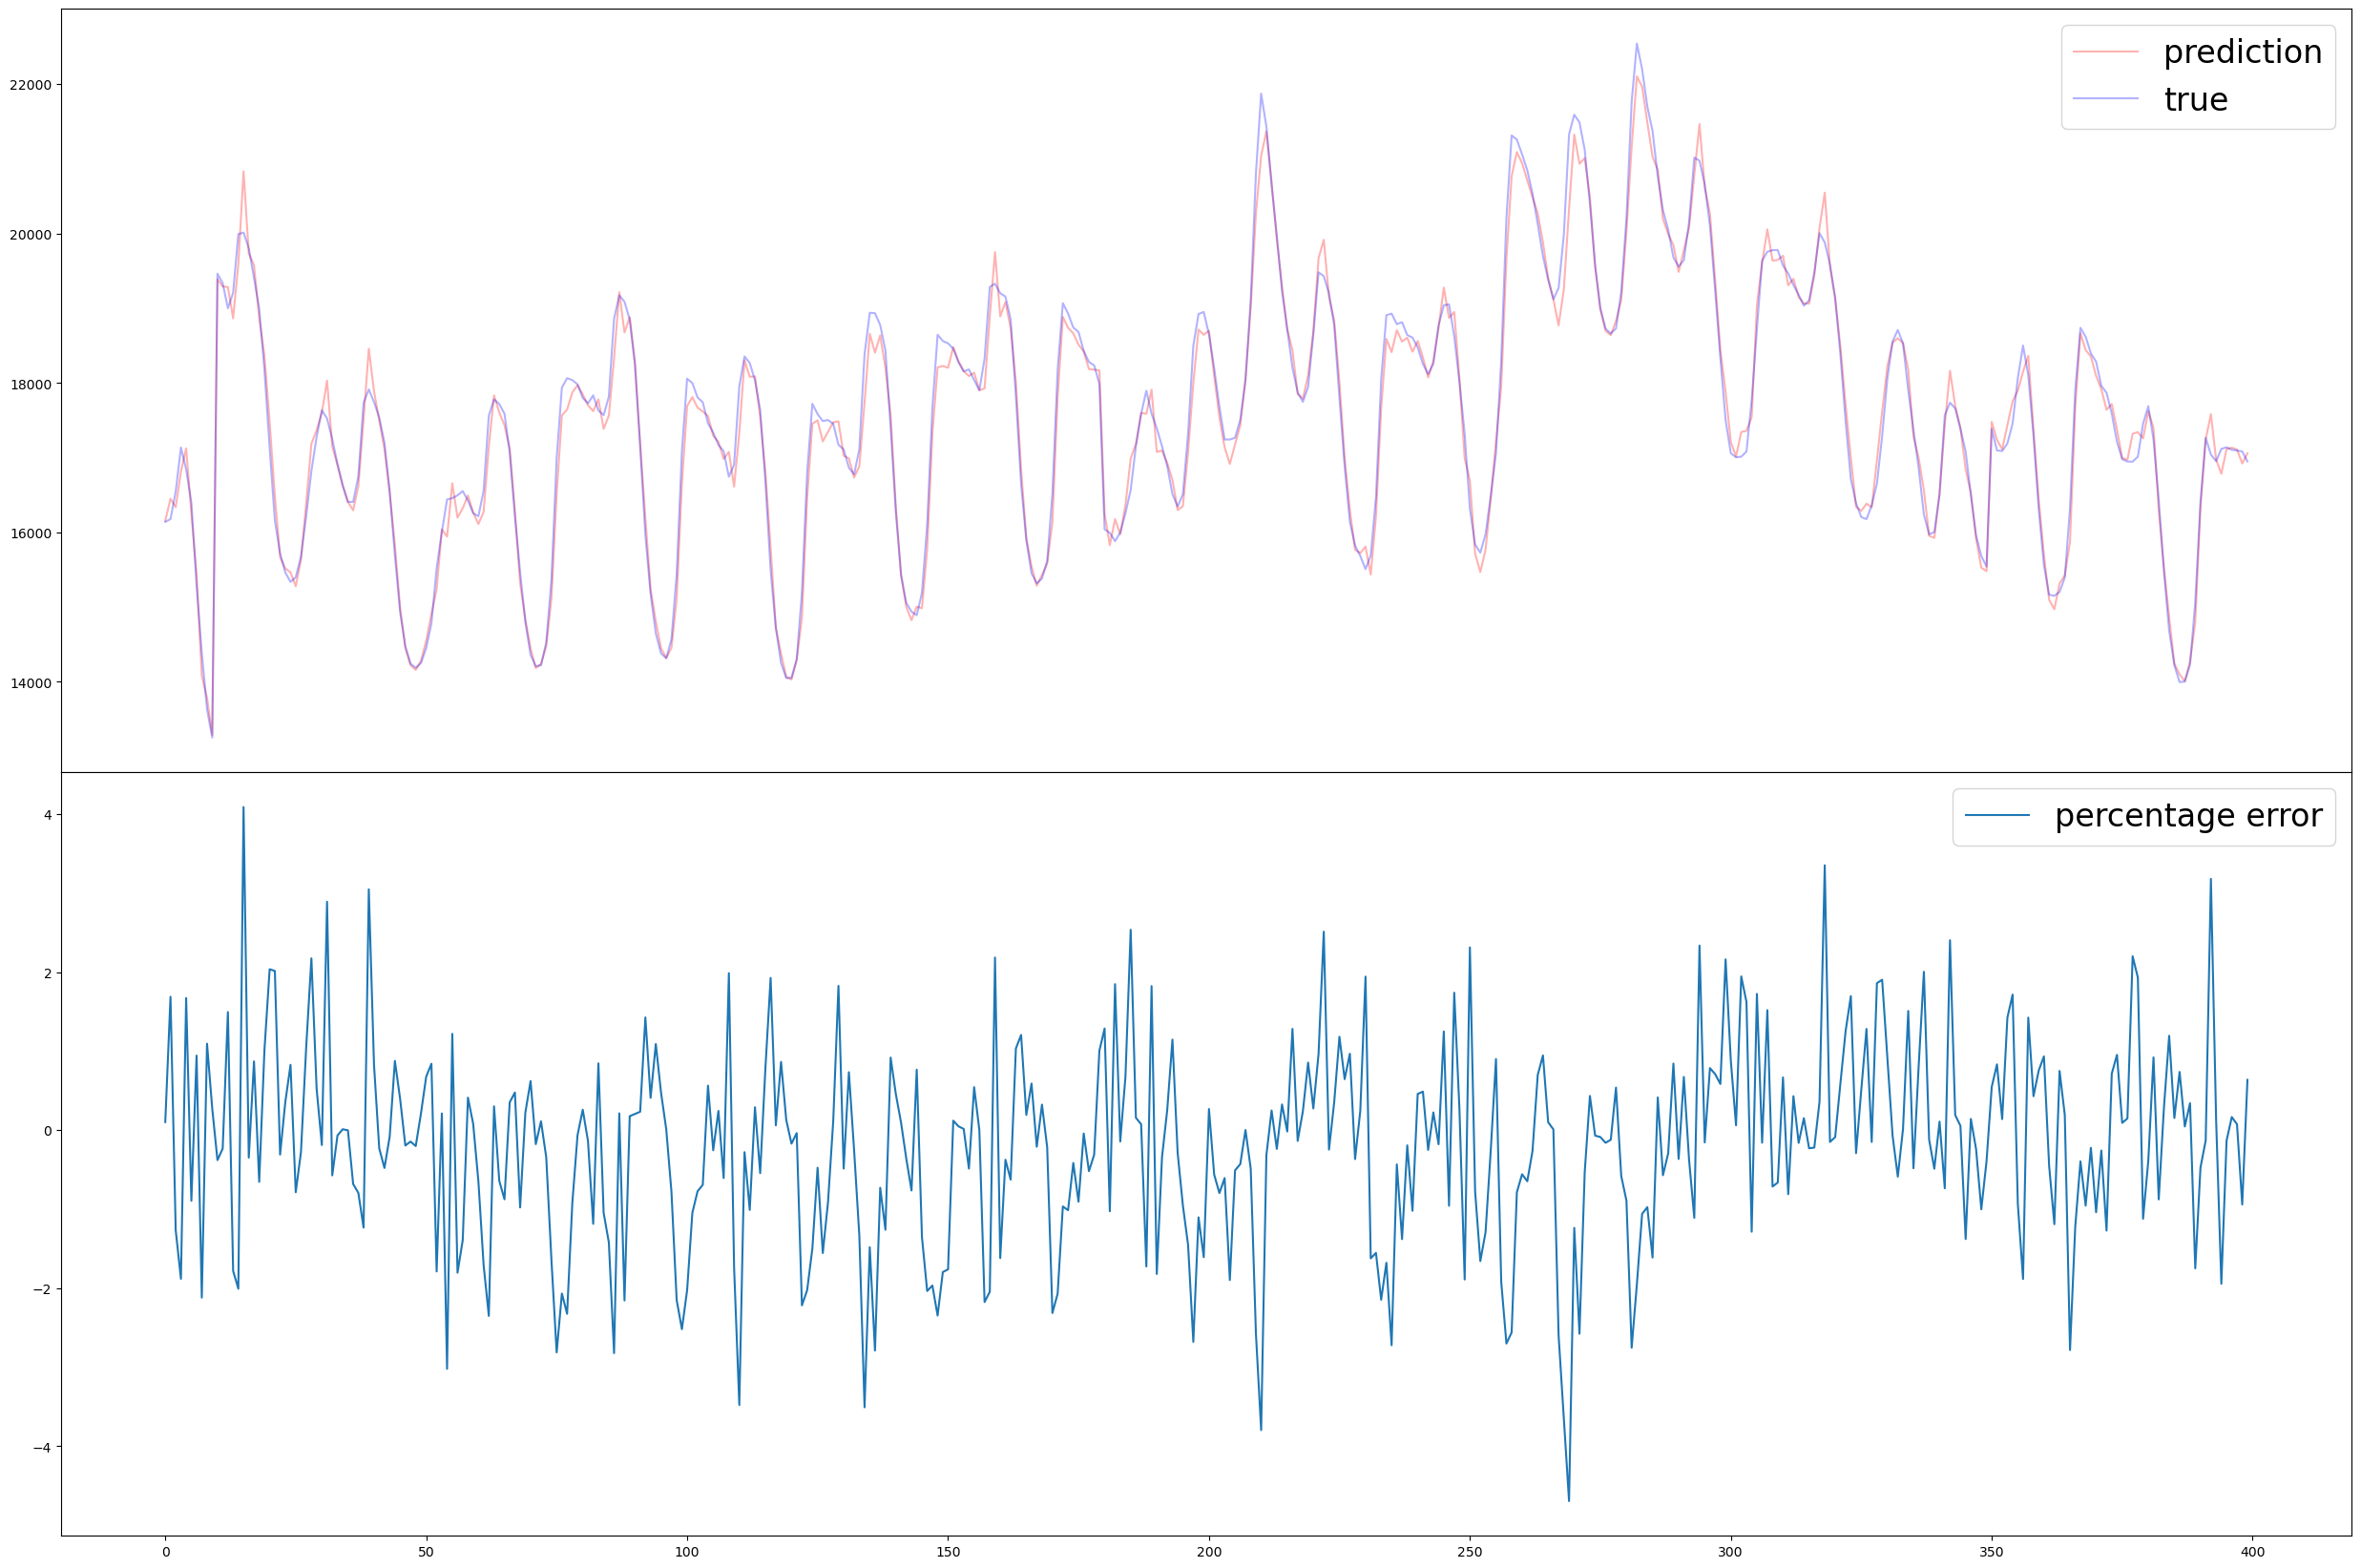

In [19]:
iterable = iter(test_dataloader)
next(iterable)
for _ in range(10):
    X_tmp, Y_tmp = next(iterable)
    X_tmp = X_tmp[:batch_size, :, :]
    Y_tmp = Y_tmp[:batch_size, :]
    y_hat = target_scaler.inverse_transform(model(X_tmp).detach())
    y_true = target_scaler.inverse_transform(Y_tmp.detach())
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (30, 20), sharex = True)
    plt.subplots_adjust(
    left=0.1,      # Left margin
    right=0.9,     # Right margin
    bottom=0.1,    # Bottom margin
    top=0.9,       # Top margin
    wspace=0.4,    # Horizontal space between subplots
    hspace=0.0001     # Vertical space between subplots
)
    axs[0].plot(y_hat, alpha = 0.3, label = 'prediction', c = 'red')
    axs[0].plot(y_true, c = 'blue', label = 'true', alpha = 0.3 )
    axs[1].plot((y_hat-y_true)/y_true*100, label = 'percentage error' )
    axs[0].legend(fontsize = 24)
    axs[1].legend(fontsize = 24)
    print('\n', '\n')
    plt.show()